In [0]:
from google.colab import drive
drive.mount('/content/drive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/drive


# Generate Synthetic data


In [0]:
import pandas as pd
import numpy as np
import statsmodels.api as sm
from statsmodels.tsa.arima_process import arma_generate_sample
n = int(3000)
# alpha1 = 0.666, alpha2 = -.333
alphas = np.array([.1])
betas = np.array([0.])

# Python requires us to specify the zero-lag value which is 1
# Also note that the alphas for the AR model must be negated
# We also set the betas for the MA equal to 0 for an AR(p) model
# For more information see the examples at statsmodels.org
ar = np.r_[1, -alphas]
ma = np.r_[1, betas]
# # AR(2)
# ar2 = arma_generate_sample(ar=ar, ma=ma, nsample=n) 
# plt.figure(figsize=(20,5))
# plt.plot( ar2)

T_1 =  arma_generate_sample(ar=ar, ma=ma, nsample=n).reshape(-1,1)
T_2 = arma_generate_sample(ar=ar, ma=ma, nsample=n).reshape(-1,1)
T_3 = arma_generate_sample(ar=ar, ma=ma, nsample=n).reshape(-1,1)
T_4 = arma_generate_sample(ar=ar, ma=ma, nsample=n).reshape(-1,1)
T_5 = arma_generate_sample(ar=ar, ma=ma, nsample=n).reshape(-1,1)
M =[[1 , 0 , 0 , 0 , 1],
[0 , 1 , 0 , 0 , 1],
[0 , 0 , 1 , 0 , 1],
[0 , 0 , 0 , 1 , 1],
[1 , -1 , 0 , 0 , 1]]
delta = np.zeros((n,1))
delta_anomal = np.zeros((n,1))
delta_anomal[300:320]   = np.ones((20,1))
delta_anomal[600:610]   = np.full((10,1),-0.7)
delta_anomal[1300:1320] = np.full((20,1),2)
delta_anomal[2100:2150] = np.full((50,1),-1.5)

# delta_anomal[41:50] = np.ones((9,1))
N = np.concatenate((T_1,T_2,T_3,T_4,delta), axis=1)
N_anomal =  np.concatenate((T_1,T_2,T_3,T_4,delta_anomal), axis=1)
B = N@M
B_anomal = N_anomal@M

T_1 = B[:,0]
T_2 = B[:,1]
T_3 = B[:,2]
T_4 = B[:,3]
T_5 = B[:,4]


T_1_anomal = B_anomal[:,0]
T_2_anomal = B_anomal[:,1]
T_3_anomal = B_anomal[:,2]
T_4_anomal = B_anomal[:,3]
T_5_anomal = B_anomal[:,4]

MD_T = np.concatenate((T_1.reshape((-1,1)),T_2.reshape((-1,1)),T_3.reshape((-1,1)),T_4.reshape((-1,1)),T_5.reshape((-1,1))),axis=1)
MD_T_anomaly = np.concatenate((T_1_anomal.reshape((-1,1)),T_2_anomal.reshape((-1,1)),T_3_anomal.reshape((-1,1)),T_4_anomal.reshape((-1,1)),T_5_anomal.reshape((-1,1))),axis=1)
MD_T.shape,MD_T_anomaly.shape

labels = np.zeros((n,1))
labels[300:320]     = 1
labels[600:610]     = 1
labels[1300:1320]   = 1
labels[2100:2150]   = 1
df_synthetic = pd.DataFrame(np.concatenate((MD_T_anomaly,labels), axis = 1))
df_synthetic.columns =  np.r_[np.array(['V'+str(i) for i in range(1,6)]),['is_anomaly']]
df_synthetic

,V1,V2,V3,V4,V5,is_anomaly
0,0.496714,-1.907808,-1.114081,0.765402,-1.759773,0.0
1,-0.088593,-1.051166,-0.742339,1.149953,-0.732145,0.0
2,0.638829,-0.518722,-1.016294,0.613685,-0.282502,0.0
3,1.586913,1.835815,-0.649625,-1.881129,0.891974,0.0
4,-0.075462,0.740135,-0.279113,-0.343535,0.042024,0.0
...,...,...,...,...,...,...
2995,-0.019684,0.262047,0.081516,-1.146083,-0.822204,0.0
2996,0.255784,1.178853,1.175369,-0.187431,2.422576,0.0
2997,-1.216182,-1.099519,1.705984,0.819271,0.209554,0.0
2998,0.212558,0.357999,-0.514389,-0.018769,0.037399,0.0


# Multivariate ML

## OCSVM

In [0]:
import warnings
from sklearn.cluster import KMeans
from statsmodels.tsa.ar_model import AR
from sklearn.metrics import mean_squared_error
from math import sqrt
from pandas import read_csv
import pandas as pd
from pandas import DataFrame
from pandas import concat
import numpy as np 
from matplotlib import pyplot
from sklearn.svm import OneClassSVM
from sklearn import preprocessing
import sys

class OneClassSVM_AnomalyDetection_MV:

    @classmethod
    def from_DataFrame(cls,dataframe,window_width, dimension, nu, train_rate) -> 'OneClassSVM_AnomalyDetection_MV':
    	return cls(dataframe, dimension, window_width, nu, train_rate)

    @classmethod
    def from_file(cls, path, index_col, window_width, dimension, nu, train_rate) -> 'OneClassSVM_AnomalyDetection_MV':
    	df = read_csv(path, header=0, index_col=index_col, parse_dates=True,squeeze=True)
    	return cls(df, dimension, window_width, nu, train_rate)
     
    def __init__(self,dataframe, dimension, window_width, nu, train_rate):
        self.nu = nu
        self.df = dataframe
        self.window_width = window_width
        self.dimension = dimension
        self.window_width = window_width
		
        self.df = self.df.reset_index(drop=True)
        self.df.rename(columns={'Target':'is_anomaly'}, inplace=True)
        self.df.loc[self.df.is_anomaly == "'Anomaly'", 'is_anomaly'] = 1
        self.df.loc[self.df.is_anomaly == "'Normal'", 'is_anomaly'] = 0

        self.X_origin = self.df.iloc[:,:dimension].values
        self.Y_origin = self.df.iloc[:,-1].values

        df_sensors = pd.DataFrame(self.df.iloc[:,:dimension].values)  
        self.values = df_sensors
        self.dataframe = concat([self.df.iloc[:,:-1].shift(1), self.df.iloc[:,:-1], self.df.iloc[:,-1]], axis=1)
        self.dataframe.columns = np.r_[np.array(['V'+str(i)+'_t' for i in range(1,self.dimension+1)]),np.array(['V'+str(i)+'_t+1' for i in range(1,self.dimension+1)]),['is_anomaly']]

        self.train_size = int(len(self.values) * train_rate)

    def create_XY_lookback_dataset(self,dataset, look_back=1):
        dataX, dataY = [], []
        for i in range(len(dataset)-look_back-1):
            a = dataset[i:(i+look_back),:self.dimension]
            dataX.append(a)
            dataY.append(dataset[i + look_back,:self.dimension].reshape(-1))
        return np.array(dataX), np.array(dataY)

    def build_sets(self):

        X = self.dataframe.iloc[:,:-1].values
        self.train, self.test = X[1:self.train_size], X[self.train_size:]    
        # print('Train.len:',len(self.train),' - Test.len:', len(self.test))

        self.train_X, self.train_y = self.create_XY_lookback_dataset(self.train, self.window_width)
        self.test_X, self.test_y = self.create_XY_lookback_dataset(self.test, self.window_width)
        # print('TrainX.shape:',self.train_X.shape,' - TestX.shape:', self.test_X.shape,' - TrainY.shape:', self.train_y.shape,' - TestY.shape:', self.test_y.shape)

        self.validationsize = int(self.train_X.shape[0] * 0.1)
        self.val, self.test = self.test[:self.validationsize], self.test[self.validationsize:]
        self.val_X, self.val_y= self.test_X[:self.validationsize], self.test_y[:self.validationsize]
        self.test_X, self.test_y = self.test_X[self.validationsize:], self.test_y[self.validationsize:]
        
    def __build_sets(self):
	
        X = self.dataframe.iloc[:,:-1].values
        self.train, self.test = X[1:self.train_size], X[self.train_size:]    
        # print('Train.len:',len(self.train),' - Test.len:', len(self.test))

        self.train_X, self.train_y = self.create_XY_lookback_dataset(self.train, self.window_width)
        self.test_X, self.test_y = self.create_XY_lookback_dataset(self.test, self.window_width)
        # print('TrainX.shape:',self.train_X.shape,' - TestX.shape:', self.test_X.shape,' - TrainY.shape:', self.train_y.shape,' - TestY.shape:', self.test_y.shape)

    def standardize_dataframe(self):
        X = self.dataframe.values[:,:-1]
        self.scalar = preprocessing.StandardScaler().fit(X)
        X = self.scalar.transform(X)
        self.dataframe = pd.DataFrame(np.concatenate((X,self.dataframe.values[:,-1].reshape(-1,1)),axis=1))
        self.dataframe.columns = np.r_[np.array(['V'+str(i)+'_t' for i in range(1,self.dimension+1)]),np.array(['V'+str(i)+'_t+1' for i in range(1,self.dimension+1)]),['is_anomaly']]

    def inverse_standardize_dataframe(self):
        X = self.dataframe.values[:,:-1]
        X = self.scalar.inverse_transform(X)
        self.dataframe = pd.DataFrame(np.concatenate((X,self.dataframe.values[:,-1].reshape(-1,1)),axis=1))
        self.dataframe.columns = np.r_[np.array(['V'+str(i)+'_t' for i in range(1,self.dimension+1)]),np.array(['V'+str(i)+'_t+1' for i in range(1,self.dimension+1)]),['is_anomaly']]

    def model_persistence(self, x):
        return x
        
    def create_persistence(self):
        rmse = sqrt(mean_squared_error(self.dataframe['t'].iloc[self.train_size:], self.dataframe['t+1'].iloc[self.train_size::]))
#         print('Persistent Model RMSE: %.3f' % rmse)   

    def fit(self):
        # self.create_persistence()
        self.standardize_dataframe()
        self.__build_sets()
                
        self.compute_anomalyScores()
        self.inverse_standardize_dataframe()

    def compute_anomalyScores(self):
        self.errors = np.zeros_like(self.test[:,0])
        # compute anomalies
        warnings.filterwarnings("ignore")

        for i,_ in enumerate(self.test[:-self.window_width+1]):
            sys.stdout.write('\r'+str(i)+':'+str(len(self.test) - self.window_width))

            window = self.test[i:i+self.window_width]
            clf=OneClassSVM(nu=self.nu)
            clf.fit(window)
            error = clf.decision_function(window) 
            error[error>0] = 0
            self.errors[i:i+self.window_width] += error*-10


        # normalize anomaly score
        self.errors[:-self.window_width+1] /= self.window_width
        for i,error in enumerate(self.test[-self.window_width+1:]):
            self.errors[-self.window_width + 1 + i] /=self.window_width-(i+1)

        # self.errors_original = self.errors
        # scalar = preprocessing.MinMaxScaler((0,1)).fit(self.errors.reshape(-1,1))
        # self.errors = scalar.transform(self.errors.reshape(-1,1))*10


    def plot(self):
        fig, axes = plt.subplots(nrows=3, ncols=3, dpi=120, figsize=(50,5))
        for i, ax in enumerate(axes.flatten()):
            data = self.df[self.df.columns[i]].iloc[:200]
            ax.plot(self.test_y[:,i], color='green',  linewidth=0.5,label='True Values')
            ax.plot(self.predictions[:,i], color='blue',  linewidth=0.5,label='Predictions')
            ax.plot(self.errors[:,i], color = 'red',  linewidth=0.5, label='Errors')
            ax.legend()
            
        plt.show()

    def get_roc_auc(self, plot=True, verbose=True):
        # get the predicted errors of the anomaly points
        indices = self.df[self.df['is_anomaly']==1].index >self.train_size
        true_anomaly_predicted_errors = self.errors[self.df[self.df['is_anomaly']==1].index[indices] - self.train_size ]
        if len(true_anomaly_predicted_errors) == 0:
            return np.nan
        # sort them 
        true_anomaly_predicted_errors = np.sort(true_anomaly_predicted_errors,axis=0).reshape(-1)
        true_anomaly_predicted_errors_extended = np.r_[np.linspace(0,true_anomaly_predicted_errors[0],40)[:-1],true_anomaly_predicted_errors]
        true_anomaly_predicted_errors_extended = np.r_[true_anomaly_predicted_errors_extended, true_anomaly_predicted_errors_extended[-1] + np.mean(true_anomaly_predicted_errors_extended)]
                # now iterate thru the predicted errors from small to big
        # for each value look how much other points have equal or bigger error
        FPR = [] # fp/n  https://en.wikipedia.org/wiki/Sensitivity_and_specificity
        TPR = [] # tp/p
        p = len(true_anomaly_predicted_errors)
        Thresholds = []
        for predictederror in true_anomaly_predicted_errors_extended:
            threshold = predictederror
            tp = len(true_anomaly_predicted_errors[true_anomaly_predicted_errors>= threshold])
            fp = len(self.errors[self.errors>=threshold])-len(true_anomaly_predicted_errors[true_anomaly_predicted_errors>=threshold])
            
            fpr =fp/len(self.errors)
            FPR.append(fpr)
            TPR.append(tp/p)
            if verbose:
                print("Threshold: {0:25}  - FP: {1:4} - TP: {2:4} - FPR: {3:21} - TPR: {4:4}".format(threshold,fp, tp, fpr, tp/p))

        import matplotlib.pyplot as plt
        if plot:
            plt.figure()
            plt.axis([0, 1, 0, 1])
            plt.plot(FPR,TPR)
            plt.show() 

        # This is the AUC
        from sklearn.metrics import auc
        print('AUC: ' ,auc(FPR,TPR)        )
        return auc(FPR,TPR)



# iforest = OneClassSVM_AnomalyDetection.from_file('drive/My Drive/MT/Experiments/Multivariate/NASA_Shuttle/40903.csv',None,30,3,0.7,0.3)
# iforest.fit()
# auc = iforest.get_roc_auc(verbose=False,plot=True)


### Evaluation

/usr/local/lib/python3.6/dist-packages/pandas/core/ops/__init__.py:1115: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  result = method(y)


1750:1750

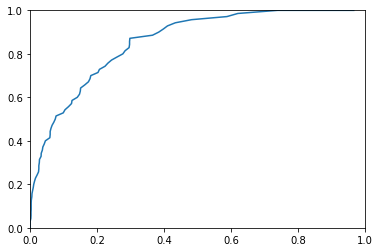

AUC:  0.8233639455782313
Time:  15


In [0]:
# dataframe,window_width, dimension, nu, train_rate

import datetime
startTime = datetime.datetime.now()
import glob
ocsvm = OneClassSVM_AnomalyDetection_MV.from_DataFrame(df_synthetic,350,5,0.9,0.3)
ocsvm.fit()
auc = ocsvm.get_roc_auc(verbose=False,plot=True)

endTime = datetime.datetime.now()
diff = endTime - startTime
print('Time: ',diff.seconds)

In [0]:
# dataframe,window_width, dimension, nu, train_rate

import datetime
startTime = datetime.datetime.now()
import glob
ocsvm = OneClassSVM_AnomalyDetection_MV.from_file('drive/My Drive/MT/Experiments/Multivariate/NASA_Shuttle/40903.csv',None,350,3,0.9,0.3)
ocsvm.fit()
auc = ocsvm.get_roc_auc(verbose=False,plot=True)

endTime = datetime.datetime.now()
diff = endTime - startTime
print('Time: ',diff.seconds)

FileNotFoundError: ignored

## XGBoost Multivariate

In [0]:
import warnings
from sklearn.cluster import KMeans
from statsmodels.tsa.ar_model import AR
from sklearn.metrics import mean_squared_error
from math import sqrt
from pandas import read_csv
import pandas as pd
from pandas import DataFrame
from pandas import concat
import numpy as np 
from matplotlib import pyplot
from xgboost import XGBRegressor
from sklearn import preprocessing
import sys
from tensorflow import set_random_seed
set_random_seed(42)
from numpy.random import seed
import numpy
import matplotlib.pyplot as plt
import pandas
import math
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error
import numpy as np
from keras.layers import Conv1D,MaxPooling1D,Flatten
seed(42)
from keras import regularizers

def warn(*args, **kwargs):
    pass
    
class XGB_AnomalyDetection_ML:

    @classmethod
    def from_DataFrame(cls,dataframe,window_width, dimension, train_rate) -> 'XGB_AnomalyDetection_ML':
    	return cls(dataframe, window_width, dimension, train_rate)

    @classmethod
    def from_file(cls, path, index_col, window_width, dimension, train_rate) -> 'XGB_AnomalyDetection_ML':
    	df = read_csv(path, header=0, index_col=index_col, parse_dates=True,squeeze=True)
    	return cls(df, window_width, dimension, train_rate)
     
    def __init__(self,df, window_width, dimension, train_rate):

        self.dimension = dimension
        self.window_width = window_width


        self.df = df
        self.df = self.df.reset_index(drop=True)
        self.df.rename(columns={'Target':'is_anomaly'}, inplace=True)
        self.df.loc[self.df.is_anomaly == "'Anomaly'", 'is_anomaly'] = 1
        self.df.loc[self.df.is_anomaly == "'Normal'", 'is_anomaly'] = 0

        df_sensors = pd.DataFrame(self.df.iloc[:,:dimension].values)  
        self.values = df_sensors
        self.dataframe = concat([self.df.iloc[:,:-1].shift(1), self.df.iloc[:,:-1], self.df.iloc[:,-1]], axis=1)
        self.dataframe.columns = np.r_[np.array(['V'+str(i)+'_t' for i in range(1,self.dimension+1)]),np.array(['V'+str(i)+'_t+1' for i in range(1,self.dimension+1)]),['is_anomaly']]

        # self.dataframe = concat([self.values.shift(1), self.values], axis=1)
        # self.dataframe.columns = ['t', 't+1']

        self.train_size = int(len(self.values) * train_rate)  

    def reset_dataframe(self, df, dimension, train_rate):
        self.df = df
        self.dimension = dimension
        self.df = self.df.reset_index(drop=True)
        self.df.rename(columns={'Target':'is_anomaly'}, inplace=True)
        self.df.loc[self.df.is_anomaly == "'Anomaly'", 'is_anomaly'] = 1
        self.df.loc[self.df.is_anomaly == "'Normal'", 'is_anomaly'] = 0

        df_sensors = pd.DataFrame(self.df.iloc[:,:dimension].values)  
        self.values = df_sensors
        self.dataframe = concat([self.df.iloc[:,:-1].shift(1), self.df.iloc[:,:-1], self.df.iloc[:,-1]], axis=1)
        self.dataframe.columns = np.r_[np.array(['V'+str(i)+'_t' for i in range(1,self.dimension+1)]),np.array(['V'+str(i)+'_t+1' for i in range(1,self.dimension+1)]),['is_anomaly']]



        self.train_size = int(len(self.values) * train_rate)         

    def create_XY_lookback_dataset(self,dataset, look_back=1):
        dataX, dataY = [], []
        for i in range(len(dataset)-look_back-1):
            a = dataset[i:(i+look_back),:self.dimension]
            dataX.append(a.reshape(-1))
            dataY.append(dataset[i + look_back,:self.dimension].reshape(-1))
        return numpy.array(dataX), numpy.array(dataY)
    
    def getWindowedVectors(self, X):
        vectors = np.zeros((len(X) - self.window_width+1,self.window_width))
        for i,_ in enumerate(X[:-self.window_width+1]):
            vectors[i] = X[i:i+self.window_width]
        return vectors

    def __build_sets(self):

        X = self.dataframe.iloc[:,:-1].values
        self.train, self.test = X[1:self.train_size], X[self.train_size:]    
        # print('Train.len:',len(self.train),' - Test.len:', len(self.test))

        self.train_X, self.train_y = self.create_XY_lookback_dataset(self.train, self.window_width)
        self.test_X, self.test_y = self.create_XY_lookback_dataset(self.test, self.window_width)
        # print('TrainX.shape:',self.train_X.shape,' - TestX.shape:', self.test_X.shape,' - TrainY.shape:', self.train_y.shape,' - TestY.shape:', self.test_y.shape)

        self.validationsize = int(self.train_X.shape[0] * 0.1)
        self.val, self.test = self.test[:self.validationsize], self.test[self.validationsize:]
        self.val_X, self.val_y= self.test_X[:self.validationsize], self.test_y[:self.validationsize]
        self.test_X, self.test_y = self.test_X[self.validationsize:], self.test_y[self.validationsize:]

    def standardize_dataframe(self):
        X = self.dataframe.values[:,:-1]
        self.scalar = preprocessing.StandardScaler().fit(X)
        X = self.scalar.transform(X)
        self.dataframe = pd.DataFrame(np.concatenate((X,self.dataframe.values[:,-1].reshape(-1,1)),axis=1))
        self.dataframe.columns = np.r_[np.array(['V'+str(i)+'_t' for i in range(1,self.dimension+1)]),np.array(['V'+str(i)+'_t+1' for i in range(1,self.dimension+1)]),['is_anomaly']]

    def inverse_standardize_dataframe(self):
        X = self.dataframe.values[:,:-1]
        X = self.scalar.inverse_transform(X)
        self.dataframe = pd.DataFrame(np.concatenate((X,self.dataframe.values[:,-1].reshape(-1,1)),axis=1))
        self.dataframe.columns = np.r_[np.array(['V'+str(i)+'_t' for i in range(1,self.dimension+1)]),np.array(['V'+str(i)+'_t+1' for i in range(1,self.dimension+1)]),['is_anomaly']]




    def model_persistence(self, x):
        return x
        
    def create_persistence(self):
        rmse = sqrt(mean_squared_error(self.dataframe.iloc[self.train_size:,:self.dimension], self.dataframe.iloc[self.train_size:,self.dimension:-1]))
        # print('Persistent Model RMSE: %.3f' % rmse)   

    def fit(self):
        self.create_persistence()
        self.standardize_dataframe()
        self.__build_sets()
                
        self.compute_anomalyScores()
        self.inverse_standardize_dataframe()
        self.compute_Errors_RMSE()


    def plotTraining(self):
        history_dict = self.history.history
        loss_values = history_dict['loss'][1:]
        val_loss_values = history_dict['val_loss'][1:]
        self.n_epochs = range(2, self.n_epochs + 1)
        plt.plot(self.n_epochs, loss_values, 'bo', label='Training loss')
        plt.plot(self.n_epochs, val_loss_values, 'b', label='Validation loss')
        plt.title('Training and validation loss')
        plt.xlabel('Epochs')
        plt.ylabel('Loss')
        plt.legend()
        plt.show()

    def compute_anomalyScores(self):
        from sklearn.multioutput import MultiOutputRegressor

        # fitting
        multioutputregressor = MultiOutputRegressor(XGBRegressor(objective='reg:linear')).fit(self.train_X, self.train_y)

        # predicting
        self.predictions = multioutputregressor.predict(self.test_X) 
        # # self.train_X = numpy.reshape(self.train_X, (self.train_X.shape[0],self.dimension,self.train_X.shape[1]))
        # # self.test_X = numpy.reshape(self.test_X, (self.test_X.shape[0],self.dimension, self.test_X.shape[1]))

        # from keras.layers import Conv1D,MaxPooling1D,Flatten
        # self.model = Sequential()

        # self.model = Sequential()
        # self.model.add(LSTM(self.n_filters[0], batch_input_shape=(1, self.window_width, self.dimension), stateful=True, return_sequences=True))
        # self.model.add(LSTM(self.n_filters[1], batch_input_shape=(1, self.window_width, self.dimension), stateful=True))
        # self.model.add(Dense(self.dimension))
        # self.model.compile(optimizer='adam', loss='mse')
        # for i in range(self.n_epochs):
        #     sys.stdout.write('\r'+str(i)+':'+str(self.n_epochs))
        #     self.model.fit(self.train_X, self.train_y,validation_data=(self.val_X,self.val_y), epochs=1, batch_size=1, verbose=0, shuffle=False)
        #     self.model.reset_states()
        # print('')

        # # self.plotTraining()
        # self.predictions = self.model.predict(self.test_X, batch_size = 1)


    def compute_Errors_RMSE(self):

        rmse = sqrt(mean_squared_error(self.test_y.reshape(self.predictions.shape), self.predictions))
        self.errors = np.absolute(self.test_y.reshape(self.predictions.shape) - np.array(self.predictions))
        # print('Prediction Test RMS        E: %.3f' % rmse)       
   

    def plot(self):
        fig, axes = plt.subplots(nrows=3, ncols=3, dpi=120, figsize=(50,5))
        for i, ax in enumerate(axes.flatten()):
            data = self.df[self.df.columns[i]].iloc[:200]
            ax.plot(self.test_y[:,i], color='green',  linewidth=0.5,label='True Values')
            ax.plot(self.predictions[:,i], color='blue',  linewidth=0.5,label='Predictions')
            ax.plot(self.errors[:,i], color = 'red',  linewidth=0.5, label='Errors')
            ax.legend()
            
        plt.show()

    def get_roc_auc(self, plot=True, verbose=True):
        self.euclidean_errors = numpy.linalg.norm(self.test_y.reshape(self.predictions.shape) - self.predictions, axis=1)
        # get the predicted errors of the anomaly points
        indices = self.df[self.df['is_anomaly']==1].index >self.train_size + self.validationsize
        true_anomaly_predicted_errors = self.euclidean_errors[self.df[self.df['is_anomaly']==1].index[indices] - self.train_size - self.validationsize - self.window_width -1]
        if len(true_anomaly_predicted_errors) == 0:
            return np.nan
        # sort them 
        true_anomaly_predicted_errors = np.sort(true_anomaly_predicted_errors,axis=0).reshape(-1)
        true_anomaly_predicted_errors_extended = np.r_[np.linspace(0,true_anomaly_predicted_errors[0],40)[:-1],true_anomaly_predicted_errors]
        true_anomaly_predicted_errors_extended = np.r_[true_anomaly_predicted_errors_extended, true_anomaly_predicted_errors_extended[-1] + np.mean(true_anomaly_predicted_errors_extended)]
                # now iterate thru the predicted errors from small to big
        # for each value look how much other points have equal or bigger error
        FPR = [] # fp/n  https://en.wikipedia.org/wiki/Sensitivity_and_specificity
        TPR = [] # tp/p
        p = len(true_anomaly_predicted_errors)
        Thresholds = []
        for predictederror in true_anomaly_predicted_errors_extended:
            threshold = predictederror
            tp = len(true_anomaly_predicted_errors[true_anomaly_predicted_errors>= threshold])
            fp = len(self.euclidean_errors[self.euclidean_errors>=threshold])-len(true_anomaly_predicted_errors[true_anomaly_predicted_errors>=threshold])
            
            fpr =fp/len(self.euclidean_errors)
            FPR.append(fpr)
            TPR.append(tp/p)
            if verbose:
                print("Threshold: {0:25}  - FP: {1:4} - TP: {2:4} - FPR: {3:21} - TPR: {4:4}".format(threshold,fp, tp, fpr, tp/p))

        import matplotlib.pyplot as plt
        if plot:
            plt.figure()
            plt.axis([0, 1, 0, 1])
            plt.plot(FPR,TPR)
            plt.show() 

        # This is the AUC
        from sklearn.metrics import auc
        print('AUC: ' ,auc(FPR,TPR)        )
        return auc(FPR,TPR)

# filters = [[8,8,8,8], [4,4,4,4], [4,8,16,32], [16,32,48,64],  [32,64,12,24],[128,128,128,128],[64,64,64,64],[256,256,256,256],[128,256,512,1024]]
# kernelsizes = [2,3,4,6,8,16]
# dense = [18,36,72,144]



# xgb = XGB_ML_AnomalyDetection('drive/My Drive/MT/Experiments/Multivariate/NASA_Shuttle/40903.csv',13,3,0.3)
# # xgb.reset_dataframe(df,5, 0.3)
# xgb.fit()
# # # cnn.plot()
# auc = xgb.get_roc_auc(verbose=False,plot=True)


# print(best_auc)

Using TensorFlow backend.


### Evaluation

[20:36:39] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[20:36:42] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[20:36:44] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[20:36:47] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[20:36:49] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


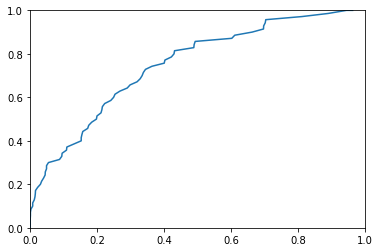

AUC:  0.7128623729826657
Time:  12


In [0]:
import datetime
startTime = datetime.datetime.now()
import glob
xgb = XGB_AnomalyDetection_ML.from_DataFrame(df_synthetic,108,5,0.3)
xgb.fit()
auc = xgb.get_roc_auc(verbose=False,plot=True)

endTime = datetime.datetime.now()
diff = endTime - startTime
print('Time: ',diff.seconds)

# Univariate Detector after Projection

## AR

In [0]:
from statsmodels.tsa.ar_model import AR
from sklearn.metrics import mean_squared_error
from math import sqrt
from pandas import read_csv
import pandas as pd
from pandas import DataFrame
from pandas import concat
import numpy as np 
from matplotlib import pyplot
import sys

class AR_Compact:

    def model_persistence(self, x):
        return x

    def create_persistence(self):
        predictions = list()
        for x in self.test_X:
            yhat = self.model_persistence(x)
            predictions.append(yhat)
        rmse = sqrt(mean_squared_error(self.test_y, predictions))
        # print('Train shape', self.train_X.shape, ' - Test shape:' , self.test_X.shape)
        # print('Persistent Model RMSE: %.3f' % rmse)     
        

    @classmethod
    def from_DataFrame(cls,dataframe, train_rate) -> 'AR_Compact':
    	return cls(dataframe, train_rate)

    @classmethod
    def from_file(cls, file: str, train_rate) -> 'AR_Compact':
    	df = read_csv(path, header=0, index_col=0, parse_dates=True,squeeze=True)
    	return cls(df, train_rate)

    
    def __init__(self,df, train_rate):
        self.df = df
        self.df = self.df.reset_index(drop=True)
        self.df.rename(columns={'anomaly':'is_anomaly'}, inplace=True)

        series = pd.DataFrame(self.df.iloc[:,0].values)  
        self.values = DataFrame(series.values)
        self.dataframe = concat([self.values.shift(1), self.values], axis=1)
        self.dataframe.columns = ['t', 't+1']

        self.train_size = int(len(self.values) * train_rate)

        self.train, self.test = self.dataframe.values[1:self.train_size], self.dataframe.values[self.train_size:]
        self.train_X, self.train_y = self.train[:,0], self.train[:,1]
        self.test_X, self.test_y = self.test[:,0], self.test[:,1]     
        self.create_persistence()

        # X = (self.dataframe['t+1'] - self.dataframe['t']).values
        X = series.values

        self.train, self.test = X[1:self.train_size], X[self.train_size:]

          
    def fit(self, verbose=False):
        self.model = AR(self.train)
        self.model_fit = self.model.fit()
        self.window = self.model_fit.k_ar
        self.coef = self.model_fit.params  
        if verbose:      
            print('Lag: %s' % self.model_fit.k_ar)
            print('Coefficients: %s' % self.model_fit.params)

    
    def predict(self):
        self.history = self.train[len(self.train)-self.window:]
        self.history = [self.history[i] for i in range(len(self.history))]
        self.predictions = list()
        for t in range(len(self.test)):
            length = len(self.history)
            lag = [self.history[i] for i in range(length-self.window,length)]
            yhat = self.coef[0]
            for d in range(self.window):
                yhat += self.coef[d+1] * lag[self.window-d-1]
            obs = self.test[t]
            self.predictions.append(yhat)
            self.history.append(obs)        
        # for i in range(len(predictions)):
        #     print('predicted=%f, expected=%f' % (predictions[i], test[i]))
        rmse = sqrt(mean_squared_error(self.test, self.predictions))
        self.errors = np.absolute(self.test - np.array(self.predictions))
        # print('Prediction Test RMSE: %.3f' % rmse)
    def plot(self):
        # plot predicted error
        df_test = pd.DataFrame(self.df.iloc[self.train_size:].values)

        pyplot.figure(figsize=(50,5))
        pyplot.plot(self.test,color ='blue', linewidth=0.5)
        pyplot.plot(self.predictions, color='green',  linewidth=0.5)
        pyplot.plot(self.errors, color = 'red',  linewidth=0.5)
        pyplot.plot(df_test[df_test[1]==1.].index, df_test[df_test[1]==1.].iloc[:,0].values,'ro')
        pyplot.show()

    # def plot(self):
    #     # plot predicted error
    #     indices = self.df[self.df['is_anomaly']==1].index >self.train_size
    #     pyplot.figure(figsize=(50,5))
    #     pyplot.plot(self.test, color='green',  linewidth=0.5,label='True Values')
    #     pyplot.plot(self.predictions, color='blue',  linewidth=0.5,label='Predictions')
    #     pyplot.plot(self.errors, color = 'red',  linewidth=0.5, label='Errors')
    #     pyplot.plot(self.df[self.df['is_anomaly']==1].index[indices] - self.train_size, self.test[self.df[self.df['is_anomaly']==1].index[indices] - self.train_size -1], linestyle="",marker=".", label='Anomalies')
    #     pyplot.legend()
    #     pyplot.show()

    def get_roc_auc(self, plot=True, verbose=True):
        # get the predicted errors of the anomaly points
        indices = self.df[self.df['is_anomaly']==1].index >self.train_size
        true_anomaly_predicted_errors = self.errors[self.df[self.df['is_anomaly']==1].index[indices] - self.train_size]
        if len(true_anomaly_predicted_errors) == 0:
            return np.nan
        # sort them 
        true_anomaly_predicted_errors = np.sort(true_anomaly_predicted_errors,axis=0).reshape(-1)
        true_anomaly_predicted_errors_extended = np.r_[np.linspace(0,true_anomaly_predicted_errors[0],40)[:-1],true_anomaly_predicted_errors]
        true_anomaly_predicted_errors_extended = np.r_[true_anomaly_predicted_errors_extended, max(true_anomaly_predicted_errors_extended[-1] + np.mean(true_anomaly_predicted_errors_extended),np.max(self.errors) + np.mean(self.errors))]
                # now iterate thru the predicted errors from small to big
        # for each value look how much other points have equal or bigger error
        FPR = [] # fp/n  https://en.wikipedia.org/wiki/Sensitivity_and_specificity
        TPR = [] # tp/p
        p = len(true_anomaly_predicted_errors)
        Thresholds = []
        for predictederror in true_anomaly_predicted_errors_extended:
            threshold = predictederror
            tp = len(true_anomaly_predicted_errors[true_anomaly_predicted_errors>= threshold])
            fp = len(self.errors[self.errors>=threshold])-len(true_anomaly_predicted_errors[true_anomaly_predicted_errors>=threshold])
            
            fpr =fp/len(self.errors)
            FPR.append(fpr)
            TPR.append(tp/p)
            if verbose:
                print("Threshold: {0:25}  - FP: {1:4} - TP: {2:4} - FPR: {3:21} - TPR: {4:4}".format(threshold,fp, tp, fpr, tp/p))

        import matplotlib.pyplot as plt
        if plot:
            plt.figure()
            plt.axis([0, 1, 0, 1])
            plt.plot(FPR,TPR)
            plt.show() 

        # This is the AUC
        from sklearn.metrics import auc
        print('AUC: ' ,auc(FPR,TPR)        )
        return auc(FPR,TPR)

# ar_model = AR_Compact('drive/My Drive/MT/Experiments/Univariate/YahooServiceNetworkTraffic/A4Benchmark/A4Benchmark-TS18.csv', 0.3)
# ar_model.fit()
# ar_model.predict()
# ar_model.plot()
# ar_model.get_roc_auc(verbose=True)

## MA

In [0]:
from statsmodels.tsa.ar_model import AR
from sklearn.metrics import mean_squared_error
from math import sqrt
from pandas import read_csv
import pandas as pd
from pandas import DataFrame
from pandas import concat
import numpy as np 
from matplotlib import pyplot

class MA:

    @classmethod
    def from_DataFrame(cls,dataframe, train_rate) -> 'MA':
    	return cls(dataframe, train_rate)

    @classmethod
    def from_file(cls, file: str, train_rate) -> 'MA':
    	df = read_csv(path, header=0, index_col=0, parse_dates=True,squeeze=True)
    	return cls(df, train_rate)

    
    def __init__(self,df, train_rate):
        self.df = df
        self.df = self.df.reset_index(drop=True)
        self.df.rename(columns={'anomaly':'is_anomaly'}, inplace=True)

        series = pd.DataFrame(self.df.iloc[:,0].values)  
        self.values = DataFrame(series.values)
        self.dataframe = concat([self.values.shift(1), self.values], axis=1)
        self.dataframe.columns = ['t', 't+1']

        X = self.dataframe.values
        self.train_size = int(len(X) * train_rate)

        self.train, self.test = self.dataframe.values[1:self.train_size], self.dataframe.values[self.train_size:]
        self.train_X, self.train_y = self.train[:,0], self.train[:,1]
        self.test_X, self.test_y = self.test[:,0], self.test[:,1]     
        # self.create_persistence()

        # X = (self.dataframe['t+1'] - self.dataframe['t']).values
        X = series.values

        # persistence model on training set
        self.train_pred = [x for x in self.train_X]
        # calculate residuals
        self.train_resid = [self.train_y[i]-self.train_pred[i] for i in range(len(self.train_pred))]

    # def __init__(self, path, train_rate):

    #     self.df = read_csv(path, header=0, index_col=0, parse_dates=True,squeeze=True)
    #     self.df = self.df.reset_index(drop=True)
    #     self.df.rename(columns={'anomaly':'is_anomaly'}, inplace=True)
    #     series = pd.DataFrame(self.df.iloc[:,0].values)  
    #     self.values = DataFrame(series.values)
    #     self.dataframe = concat([self.values.shift(1), self.values], axis=1)
    #     self.dataframe.columns = ['t', 't+1']
    #     X = self.dataframe.values

    #     self.train_size = int(len(X) * train_rate)    

    #     train, test = X[1:self.train_size], X[self.train_size:]
    #     self.train_X, self.train_y = train[:,0], train[:,1]
    #     self.test_X, self.test_y = test[:,0], test[:,1]        
    #     # persistence model on training set
    #     self.train_pred = [x for x in self.train_X]
    #     # calculate residuals
    #     self.train_resid = [self.train_y[i]-self.train_pred[i] for i in range(len(self.train_pred))]

    def fit(self, verbose=False):
        self.model = AR(self.train_resid)
        self.model_fit = self.model.fit()
        self.window = self.model_fit.k_ar
        self.coef = self.model_fit.params        
        if verbose:
            print(self.coef)

    def predict(self):
        # walk forward over time steps in test
        self.history = self.train_resid[len(self.train_resid)-self.window:]
        self.history = [self.history[i] for i in range(len(self.history))]
        self.predictions = list()
        for t in range(len(self.test_y)):
            # persistence
            yhat = self.test_X[t]
            error = self.test_y[t] - yhat
            # predict error
            length = len(self.history)
            lag = [self.history[i] for i in range(length-self.window,length)]
            pred_error = self.coef[0]
            for d in range(self.window):
                pred_error += self.coef[d+1] * lag[self.window-d-1]
            # correct the prediction
            yhat = yhat + pred_error
            self.predictions.append(yhat)
            self.history.append(error)
            # print('predicted=%f, expected=%f' % (yhat, test_y[t]))
        rmse = sqrt(mean_squared_error(self.test_y, self.predictions))
        self.errors = np.absolute(self.test_y - np.array(self.predictions))
        # print('Prediction Test RMSE: %.3f' % rmse)

    def plot(self):
        # plot predicted error
        df_test = pd.DataFrame(self.df.iloc[self.train_size:].values)

        pyplot.figure(figsize=(50,5))
        pyplot.plot(self.test_y,color ='blue', linewidth=0.5)
        pyplot.plot(self.predictions, color='green',  linewidth=0.5)
        pyplot.plot(self.errors, color = 'red',  linewidth=0.5)
        pyplot.plot(df_test[df_test[1]==1.].index, df_test[df_test[1]==1.].iloc[:,0].values,'ro')
        pyplot.show()


    def get_roc_auc(self, plot=True, verbose=True):
        # get the predicted errors of the anomaly points
        indices = self.df[self.df['is_anomaly']==1].index >self.train_size
        true_anomaly_predicted_errors = self.errors[self.df[self.df['is_anomaly']==1].index[indices] - self.train_size ]
        if len(true_anomaly_predicted_errors) == 0:
            return np.nan
        # true_anomaly_predicted_errors = self.errors[self.df[self.df['is_anomaly']==1].index - self.train_size ]
        # sort them 
        true_anomaly_predicted_errors = np.sort(true_anomaly_predicted_errors,axis=0).reshape(-1)
        true_anomaly_predicted_errors_extended = np.r_[np.linspace(0,true_anomaly_predicted_errors[0],40)[:-1],true_anomaly_predicted_errors]
        true_anomaly_predicted_errors_extended = np.r_[true_anomaly_predicted_errors_extended, true_anomaly_predicted_errors_extended[-1] + np.mean(true_anomaly_predicted_errors_extended)]
                # now iterate thru the predicted errors from small to big
        # for each value look how much other points have equal or bigger error
        FPR = [] # fp/n  https://en.wikipedia.org/wiki/Sensitivity_and_specificity
        TPR = [] # tp/p
        p = len(true_anomaly_predicted_errors)
        Thresholds = []
        for predictederror in true_anomaly_predicted_errors_extended:
            threshold = predictederror
            tp = len(true_anomaly_predicted_errors[true_anomaly_predicted_errors>= threshold])
            fp = len(self.errors[self.errors>=threshold])-len(true_anomaly_predicted_errors[true_anomaly_predicted_errors>=threshold])
            
            fpr =fp/len(self.errors)
            FPR.append(fpr)
            TPR.append(tp/p)
            if verbose:
                print("Threshold: {0:25}  - FP: {1:4} - TP: {2:4} - FPR: {3:21} - TPR: {4:4}".format(threshold,fp, tp, fpr, tp/p))

        import matplotlib.pyplot as plt
        if plot:
            plt.figure()
            plt.axis([0, 1, 0, 1])
            plt.plot(FPR,TPR)
            plt.show() 

        # This is the AUC
        from sklearn.metrics import auc
        print('AUC: ' ,auc(FPR,TPR)        )
        return auc(FPR,TPR)

# ma_model = MA('drive/My Drive/MT/Experiments/Univariate/YahooServiceNetworkTraffic/A1Benchmark/real_14.csv',0.66)
# ma_model.fit()
# ma_model.predict()
# ma_model.plot()
# ma_model.get_roc_auc(verbose=False)

## ARIMA

In [0]:
from statsmodels.tsa.ar_model import AR
from sklearn.metrics import mean_squared_error
from math import sqrt
from pandas import read_csv
import pandas as pd
from pandas import DataFrame
from pandas import concat
import numpy as np 
from matplotlib import pyplot
from statsmodels.tsa.arima_model import ARIMA
import warnings
import sys

class ARIMA_Compact:

    def model_persistence(self, x):
        return x

    def create_persistence(self):
        predictions = list()
        for x in self.test_X:
            yhat = self.model_persistence(x)
            predictions.append(yhat)
        rmse = sqrt(mean_squared_error(self.test_y, predictions))
        # print('Train shape', self.train_X.shape, ' - Test shape:' , self.test_X.shape)
        # print('Persistent Model RMSE: %.3f' % rmse)        

    @classmethod
    def from_DataFrame(cls,dataframe, train_rate,order) -> 'ARIMA_Compact':
    	return cls(dataframe, train_rate,order)

    @classmethod
    def from_file(cls, file: str, train_rate,order) -> 'ARIMA_Compact':
    	df = read_csv(path, header=0, index_col=0, parse_dates=True,squeeze=True)
    	return cls(df, train_rate,order)
     
    def __init__(self, df, train_rate, order):
        
        self.order = order
        self.df = df
        self.df = self.df.reset_index(drop=True)
        self.df.rename(columns={'anomaly':'is_anomaly'}, inplace=True)
        series = pd.DataFrame(self.df.iloc[:,0].values)  
        self.values = DataFrame(series.values)
        self.dataframe = concat([self.values.shift(1), self.values], axis=1)
        self.dataframe.columns = ['t', 't+1']
		

        self.train_size = int(len(self.values) * train_rate)

        self.train, self.test = self.dataframe.values[1:self.train_size], self.dataframe.values[self.train_size:]
        self.train_X, self.train_y = self.train[:,0], self.train[:,1]
        self.test_X, self.test_y = self.test[:,0], self.test[:,1]     
        self.create_persistence()

        X = series.values
        self.train, self.test = X[1:self.train_size], X[self.train_size:]
        self.train = self.train.astype('float32')
        self.test = self.test.astype('float32')
          
    def fit(self,  verbose=False):
        self.model = ARIMA(self.train, order = self.order)
        self.model_fit = self.model.fit(disp=0)

    
    def predict(self):
        warnings.filterwarnings("ignore")
        self.history = [x for x in self.train]
        self.predictions = list()
        for t in range(len(self.test)):
            self.model = ARIMA(self.history,order=self.order)
            self.model = self.model.fit(disp=0)
            output = self.model.forecast()
            yhat = output[0]
            self.predictions.append(yhat)
            obs = self.test[t]
            self.history.append(obs)
            sys.stdout.write('\r'+str(t)+':'+str(len(self.test)))
        print('')    
			
        # for i in range(len(predictions)):
        #     print('predicted=%f, expected=%f' % (predictions[i], test[i]))
        rmse = sqrt(mean_squared_error(self.test, self.predictions))
        self.errors = np.absolute(self.test - np.array(self.predictions))
        # print('Prediction Test RMSE: %.3f' % rmse)

    def plot(self):
        # plot predicted error
        pyplot.figure(figsize=(50,5))
        pyplot.plot(self.test_y, color='green',  linewidth=0.5,label='True Values')
        pyplot.plot(self.predictions, color='blue',  linewidth=0.5,label='Predictions')
        pyplot.plot(self.errors, color = 'red',  linewidth=0.5, label='Errors')
        pyplot.legend()
        pyplot.show()


    def get_roc_auc(self, plot=True, verbose=True):
        # get the predicted errors of the anomaly points
        indices = self.df[self.df['is_anomaly']==1].index >self.train_size
        true_anomaly_predicted_errors = self.errors[self.df[self.df['is_anomaly']==1].index[indices] - self.train_size ]
        if len(true_anomaly_predicted_errors) == 0:
            return np.nan
        # sort them 
        true_anomaly_predicted_errors = np.sort(true_anomaly_predicted_errors,axis=0).reshape(-1)
        true_anomaly_predicted_errors_extended = np.r_[np.linspace(0,true_anomaly_predicted_errors[0],40)[:-1],true_anomaly_predicted_errors]
        true_anomaly_predicted_errors_extended = np.r_[true_anomaly_predicted_errors_extended, max(true_anomaly_predicted_errors_extended[-1] + np.mean(true_anomaly_predicted_errors_extended),np.max(self.errors) + np.mean(self.errors))]
        # now iterate thru the predicted errors from small to big
        # for each value look how much other points have equal or bigger error
        FPR = [] # fp/n  https://en.wikipedia.org/wiki/Sensitivity_and_specificity
        TPR = [] # tp/p
        p = len(true_anomaly_predicted_errors)
        Thresholds = []
        for predictederror in true_anomaly_predicted_errors_extended:
            threshold = predictederror
            tp = len(true_anomaly_predicted_errors[true_anomaly_predicted_errors>= threshold])
            fp = len(self.errors[self.errors>=threshold])-len(true_anomaly_predicted_errors[true_anomaly_predicted_errors>=threshold])
            
            fpr =fp/len(self.errors)
            FPR.append(fpr)
            TPR.append(tp/p)
            if verbose:
                print("Threshold: {0:25}  - FP: {1:4} - TP: {2:4} - FPR: {3:21} - TPR: {4:4}".format(threshold,fp, tp, fpr, tp/p))

        import matplotlib.pyplot as plt
        if plot:
            plt.figure()
            plt.axis([0, 1, 0, 1])
            plt.plot(FPR,TPR)
            plt.show() 

        # This is the AUC
        from sklearn.metrics import auc
        # print('AUC: ' ,auc(FPR,TPR)        )
        return auc(FPR,TPR)

# arma_model = ARIMA_Compact('drive/My Drive/MT/Experiments/Univariate/YahooServiceNetworkTraffic/A1Benchmark/real_1.csv', 0.66, (0,0,2))
# arma_model.fit()
# arma_model.predict()
# arma_model.plot()
# arma_model.get_roc_auc(verbose=False)

## Univariate OCSVM

In [0]:
import warnings
from sklearn.cluster import KMeans
from statsmodels.tsa.ar_model import AR
from sklearn.metrics import mean_squared_error
from math import sqrt
from pandas import read_csv
import pandas as pd
from pandas import DataFrame
from pandas import concat
import numpy as np 
from matplotlib import pyplot
from sklearn.svm import OneClassSVM
from sklearn import preprocessing
import sys

class OneClassSVM_AnomalyDetection:

    @classmethod
    def from_DataFrame(cls,dataframe,window_width, nu, train_rate) -> 'OneClassSVM_AnomalyDetection':
    	return cls(dataframe, window_width, nu, train_rate)

    @classmethod
    def from_file(cls, path, window_width, nu, train_rate) -> 'OneClassSVM_AnomalyDetection':
    	df = read_csv(path, header=0, index_col=0, parse_dates=True,squeeze=True)
    	return cls(df,window_width, nu, train_rate)
     
    def __init__(self,df, window_width, nu, train_rate):
        self.df = df
        self.df = self.df.reset_index(drop=True)
        self.df.rename(columns={'anomaly':'is_anomaly'}, inplace=True)
        self.nu = nu
        self.window_width = window_width
        series = pd.DataFrame(self.df.iloc[:,0].values)  
        self.values = DataFrame(series.values)
        self.dataframe = concat([self.values.shift(1), self.values], axis=1)
        self.dataframe.columns = ['t', 't+1']

        self.train_size = int(len(self.values) * train_rate)

        # train_labeled, test_labeled = self.dataframe.values[1:self.train_size], self.dataframe.values[self.train_size:]
        # self.train_X, self.train_y = train_labeled[:,0], train_labeled[:,1]
        # self.test_X, self.test_y = test_labeled[:,0], test_labeled[:,1]     
        # self.create_persistence()

        # X = series.values
        # self.train, self.test = X[1:self.train_size], X[self.train_size:]    

    def __build_sets(self):
        train_labeled, test_labeled = self.dataframe.values[1:self.train_size], self.dataframe.values[self.train_size:]
        self.train_X, self.train_y = train_labeled[:,0], train_labeled[:,1]
        self.test_X, self.test_y = test_labeled[:,0], test_labeled[:,1]   

        X = self.dataframe.iloc[:,1].values
        self.train, self.test = X[1:self.train_size], X[self.train_size:]    

    def standardize_dataframe(self):
        X = self.dataframe.values
        self.scalar = preprocessing.StandardScaler().fit(X)
        X = self.scalar.transform(X)
        self.dataframe = pd.DataFrame(X)

    def inverse_standardize_dataframe(self):
        X = self.dataframe.values
        X = self.scalar.inverse_transform(X)
        self.dataframe = pd.DataFrame(X)



    def model_persistence(self, x):
        return x
        
    def create_persistence(self):
        rmse = sqrt(mean_squared_error(self.dataframe['t'].iloc[self.train_size:], self.dataframe['t+1'].iloc[self.train_size::]))
#         print('Persistent Model RMSE: %.3f' % rmse)   

    def fit(self):
        self.create_persistence()
        self.standardize_dataframe()
        self.__build_sets()
                
        self.compute_anomalyScores()
        self.inverse_standardize_dataframe()
    
    def getWindowedVectors(self, X):
        vectors = []
        for i,_ in enumerate(X[:-self.window_width+1]):
            vectors.append(X[i:i+self.window_width])
        return vectors

    def compute_anomalyScores(self):
        self.errors = np.zeros_like(self.test)
        # compute anomalies
        warnings.filterwarnings("ignore")

        # history = self.getWindowedVectors(self.train)

        for i,_ in enumerate(self.test[:-self.window_width+1]):
            sys.stdout.write('\r'+str(i)+':'+str(len(self.test) - self.window_width))

            window = self.test[i:i+self.window_width]
            window2D = np.zeros((len(window),2))
            window2D[:,1] = window
            clf=OneClassSVM(nu=self.nu)
            clf.fit(window2D)
            error = clf.decision_function(window2D) 
            error[error>0] = 0
            self.errors[i:i+self.window_width] += error*-10


        # normalize anomaly score
        self.errors[:-self.window_width+1] /= self.window_width
        for i,error in enumerate(self.test[-self.window_width+1:]):
            self.errors[-self.window_width + 1 + i] /=self.window_width-(i+1)

        # self.errors_original = self.errors
        # scalar = preprocessing.MinMaxScaler((0,1)).fit(self.errors.reshape(-1,1))
        # self.errors = scalar.transform(self.errors.reshape(-1,1))*10


    def plot(self):
        df_test = pd.DataFrame(self.df.iloc[self.train_size:].values)

        pyplot.figure(figsize=(50,5))
        pyplot.plot(self.test)
        pyplot.plot(self.errors, color = 'red',  linewidth=0.5)
        pyplot.plot(df_test[df_test[1]==1.].index, df_test[df_test[1]==1.].iloc[:,0].values,'ro')
        pyplot.show()

    def get_roc_auc(self, plot=True, verbose=True):
        # get the predicted errors of the anomaly points
        indices = self.df[self.df['is_anomaly']==1].index >self.train_size
        true_anomaly_predicted_errors = self.errors[self.df[self.df['is_anomaly']==1].index[indices] - self.train_size ]
        if len(true_anomaly_predicted_errors) == 0:
            return np.nan
        # sort them 
        true_anomaly_predicted_errors = np.sort(true_anomaly_predicted_errors,axis=0).reshape(-1)
        true_anomaly_predicted_errors_extended = np.r_[np.linspace(0,true_anomaly_predicted_errors[0],40)[:-1],true_anomaly_predicted_errors]
        true_anomaly_predicted_errors_extended = np.r_[true_anomaly_predicted_errors_extended, true_anomaly_predicted_errors_extended[-1] + np.mean(true_anomaly_predicted_errors_extended)]
                # now iterate thru the predicted errors from small to big
        # for each value look how much other points have equal or bigger error
        FPR = [] # fp/n  https://en.wikipedia.org/wiki/Sensitivity_and_specificity
        TPR = [] # tp/p
        p = len(true_anomaly_predicted_errors)
        Thresholds = []
        for predictederror in true_anomaly_predicted_errors_extended:
            threshold = predictederror
            tp = len(true_anomaly_predicted_errors[true_anomaly_predicted_errors>= threshold])
            fp = len(self.errors[self.errors>=threshold])-len(true_anomaly_predicted_errors[true_anomaly_predicted_errors>=threshold])
            
            fpr =fp/len(self.errors)
            FPR.append(fpr)
            TPR.append(tp/p)
            if verbose:
                print("Threshold: {0:25}  - FP: {1:4} - TP: {2:4} - FPR: {3:21} - TPR: {4:4}".format(threshold,fp, tp, fpr, tp/p))

        import matplotlib.pyplot as plt
        if plot:
            plt.figure()
            plt.axis([0, 1, 0, 1])
            plt.plot(FPR,TPR)
            plt.show() 

        # This is the AUC
        from sklearn.metrics import auc
        print('AUC: ' ,auc(FPR,TPR)        )
        return auc(FPR,TPR)


# iforest = OneClassSVM_AnomalyDetection.from_file('drive/My Drive/MT/Experiments/Univariate/YahooServiceNetworkTraffic/A1Benchmark/real_1.csv',30,0.7,0.3)
# iforest.fit()
# iforest.plot()
# iforest.get_roc_auc(verbose=False)

## XGBoost

In [0]:
import warnings
from sklearn.cluster import KMeans
from statsmodels.tsa.ar_model import AR
from sklearn.metrics import mean_squared_error
from math import sqrt
from pandas import read_csv
import pandas as pd
from pandas import DataFrame
from pandas import concat
import numpy as np 
from matplotlib import pyplot
from xgboost import XGBRegressor
from sklearn import preprocessing
import sys

class XGBRegressor_AnomalyDetection:

    @classmethod
    def from_DataFrame(cls,dataframe,window_width, train_rate) -> 'XGBRegressor_AnomalyDetection':
    	return cls(dataframe, window_width, train_rate)

    @classmethod
    def from_file(cls, path, window_width, train_rate) -> 'XGBRegressor_AnomalyDetection':
    	df = read_csv(path, header=0, index_col=0, parse_dates=True,squeeze=True)
    	return cls(df,window_width, train_rate)
         
    def __init__(self,df, window_width, train_rate):
        self.df = df
        self.df = self.df.reset_index(drop=True)
        self.df.rename(columns={'anomaly':'is_anomaly'}, inplace=True)
        self.window_width = window_width
        series = pd.DataFrame(self.df.iloc[:,0].values)  
        self.values = DataFrame(series.values)
        self.dataframe = concat([self.values.shift(1), self.values], axis=1)
        self.dataframe.columns = ['t', 't+1']

        self.train_size = int(len(self.values) * train_rate)

        # train_labeled, test_labeled = self.dataframe.values[1:self.train_size], self.dataframe.values[self.train_size:]
        # self.train_X, self.train_y = train_labeled[:,0], train_labeled[:,1]
        # self.test_X, self.test_y = test_labeled[:,0], test_labeled[:,1]     
        # self.create_persistence()

        # X = series.values
        # self.train, self.test = X[1:self.train_size], X[self.train_size:]    

    def __build_sets(self):
        train_labeled, test_labeled = self.dataframe.values[1:self.train_size], self.dataframe.values[self.train_size:]
        self.train_X, self.train_y = train_labeled[:,0], train_labeled[:,1]
        self.test_X, self.test_y = test_labeled[:,0], test_labeled[:,1]   

        X = self.dataframe.iloc[:,1].values
        self.train, self.test = X[1:self.train_size], X[self.train_size:]    

    def standardize_dataframe(self):
        X = self.dataframe.values
        self.scalar = preprocessing.StandardScaler().fit(X)
        X = self.scalar.transform(X)
        self.dataframe = pd.DataFrame(X)

    def inverse_standardize_dataframe(self):
        X = self.dataframe.values
        X = self.scalar.inverse_transform(X)
        self.dataframe = pd.DataFrame(X)



    def model_persistence(self, x):
        return x
        
    def create_persistence(self):
        rmse = sqrt(mean_squared_error(self.dataframe['t'].iloc[self.train_size:], self.dataframe['t+1'].iloc[self.train_size::]))
#         print('Persistent Model RMSE: %.3f' % rmse)   

    def fit(self):
        self.create_persistence()
        self.__build_sets()
                
        self.compute_anomalyScores()
    
    def getWindowedVectors(self, X):
        vectors = []
        for i,_ in enumerate(X[:-self.window_width+1]):
            vectors.append(X[i:i+self.window_width])
        return vectors

    def compute_anomalyScores(self):

        xgb = XGBRegressor()
        xgb.fit(self.train_X.reshape(-1,1),self.train_y.reshape(-1,1))

        self.predictions = xgb.predict(self.test_X.reshape(-1,1))
        rmse = sqrt(mean_squared_error(self.test, self.predictions))
        self.errors = np.absolute(self.test - np.array(self.predictions))
#         print('Prediction Test RMSE: %.3f' % rmse)
    

    def plot(self):
        # plot predicted error
        df_test = pd.DataFrame(self.df.iloc[self.train_size:].values)

        pyplot.figure(figsize=(50,5))
        pyplot.plot(self.test)
        pyplot.plot(self.predictions, color='blue')
        pyplot.plot(self.errors, color = 'red',  linewidth=0.5)
        pyplot.plot(df_test[df_test[1]==1.].index, df_test[df_test[1]==1.].iloc[:,0].values,'ro')
        pyplot.show()

    def get_roc_auc(self, plot=True, verbose=True):
        # get the predicted errors of the anomaly points
        indices = self.df[self.df['is_anomaly']==1].index >self.train_size
        true_anomaly_predicted_errors = self.errors[self.df[self.df['is_anomaly']==1].index[indices] - self.train_size ]
        if len(true_anomaly_predicted_errors) == 0:
            return np.nan
        # sort them 
        true_anomaly_predicted_errors = np.sort(true_anomaly_predicted_errors,axis=0).reshape(-1)
        true_anomaly_predicted_errors_extended = np.r_[np.linspace(0,true_anomaly_predicted_errors[0],40)[:-1],true_anomaly_predicted_errors]
        true_anomaly_predicted_errors_extended = np.r_[true_anomaly_predicted_errors_extended, true_anomaly_predicted_errors_extended[-1] + np.mean(true_anomaly_predicted_errors_extended)]
                # now iterate thru the predicted errors from small to big
        # for each value look how much other points have equal or bigger error
        FPR = [] # fp/n  https://en.wikipedia.org/wiki/Sensitivity_and_specificity
        TPR = [] # tp/p
        p = len(true_anomaly_predicted_errors)
        Thresholds = []
        for predictederror in true_anomaly_predicted_errors_extended:
            threshold = predictederror
            tp = len(true_anomaly_predicted_errors[true_anomaly_predicted_errors>= threshold])
            fp = len(self.errors[self.errors>=threshold])-len(true_anomaly_predicted_errors[true_anomaly_predicted_errors>=threshold])
            
            fpr =fp/len(self.errors)
            FPR.append(fpr)
            TPR.append(tp/p)
            if verbose:
                print("Threshold: {0:25}  - FP: {1:4} - TP: {2:4} - FPR: {3:21} - TPR: {4:4}".format(threshold,fp, tp, fpr, tp/p))

        import matplotlib.pyplot as plt
        if plot:
            plt.figure()
            plt.axis([0, 1, 0, 1])
            plt.plot(FPR,TPR)
            plt.show() 

        # This is the AUC
        from sklearn.metrics import auc
        print('AUC: ' ,auc(FPR,TPR)        )
        return auc(FPR,TPR)

# iforest = XGBRegressor_AnomalyDetection('Univariate/YahooServiceNetworkTraffic/A1Benchmark/real_4.csv',30,0.7,0.66)
# iforest.fit()
# iforest.plot()
# iforest.get_roc_auc(verbose=False)

# Test Projected Values


In [0]:
cl = Projection_AnomalyDetection.from_DataFrame(df_synthetic,10,5,0.3)
df = cl.get_projected_Dataframe()
df.columns = ['V1','is_anomaly']

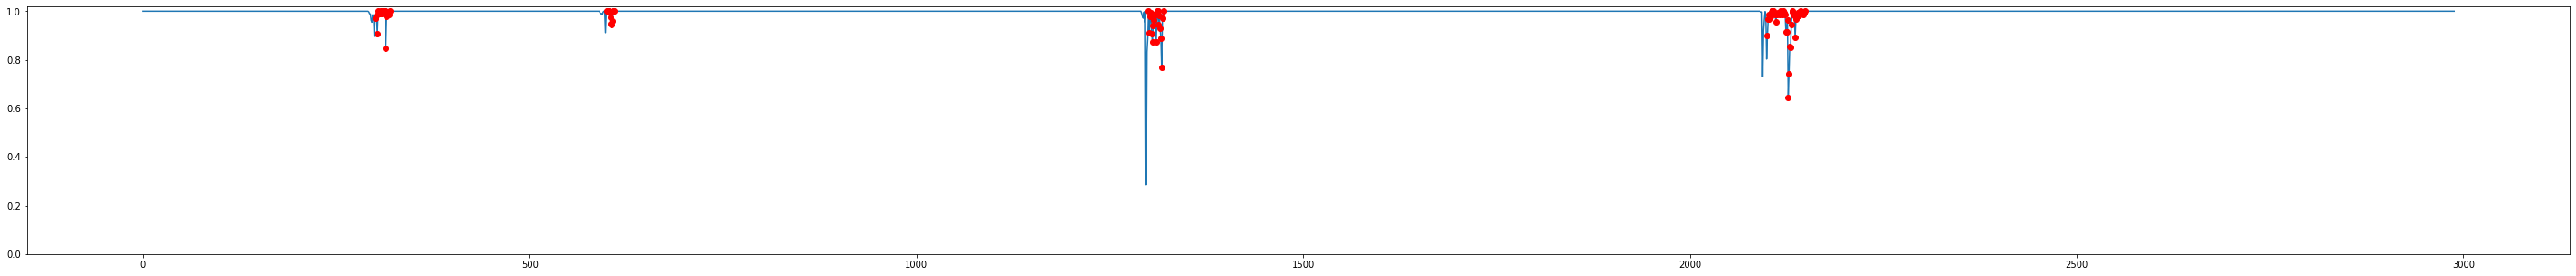

In [0]:
plt.figure(figsize=(50,5))
plt.ylim([0, 1.02])
plt.plot(df.index, df.iloc[:,0].values)

plt.plot(df[df['is_anomaly']==1].iloc[:,0],'ro')


In [0]:
# arma_model = ARIMA_Compact('drive/My Drive/MT/Experiments/Univariate/YahooServiceNetworkTraffic/A1Benchmark/real_1.csv', 0.66, (0,0,2))
# arma_model.fit()
# arma_model.predict()
# arma_model.plot()
# arma_model.get_roc_auc(verbose=False)

arima_model = ARIMA_Compact.from_DataFrame(df,0.3, (1,0,2))
arima_model.fit()
arima_model.predict()
arima_model.plot()
arima_model.get_roc_auc(verbose=False)

1192:2093

[19:58:50] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


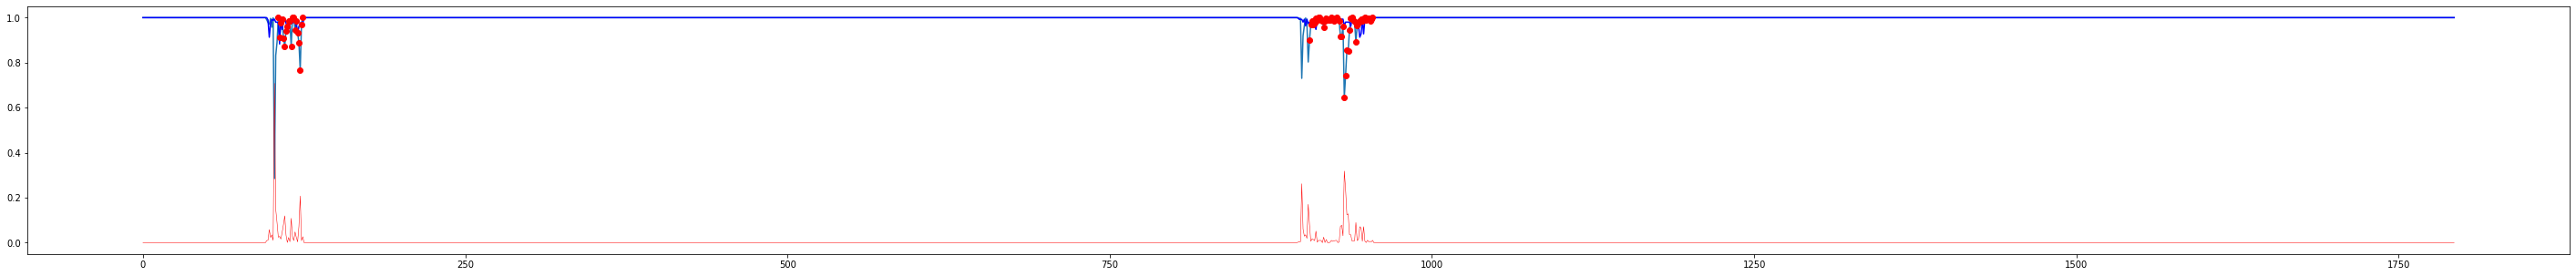

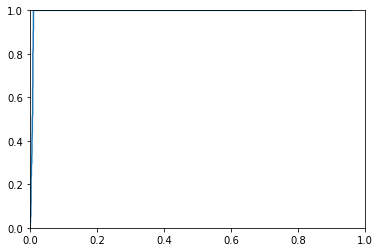

AUC:  0.9546703296703297


0.9546703296703297

In [0]:

xbg = XGBRegressor_AnomalyDetection.from_DataFrame(df,30,0.4)
xbg.fit()
xbg.plot()
xbg.get_roc_auc(verbose=False)


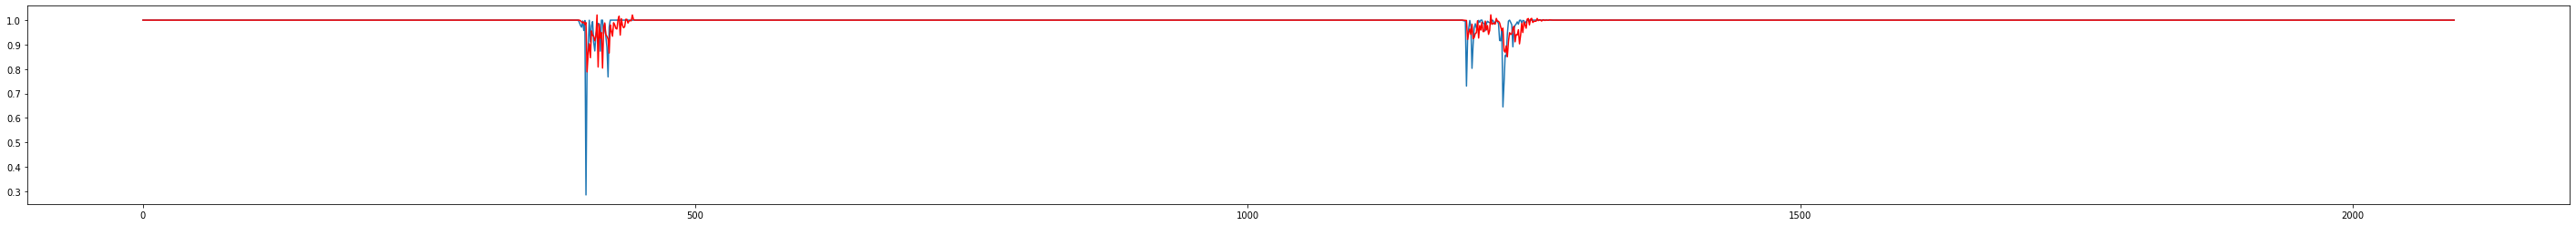

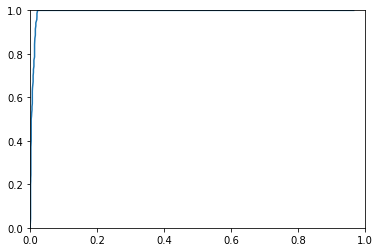

AUC:  0.9597501877004982


0.9597501877004982

In [0]:
ma = MA.from_DataFrame(df,0.3)
ma.fit()
ma.predict()
ma.plot()
ma.get_roc_auc(verbose=False)

2063:2063

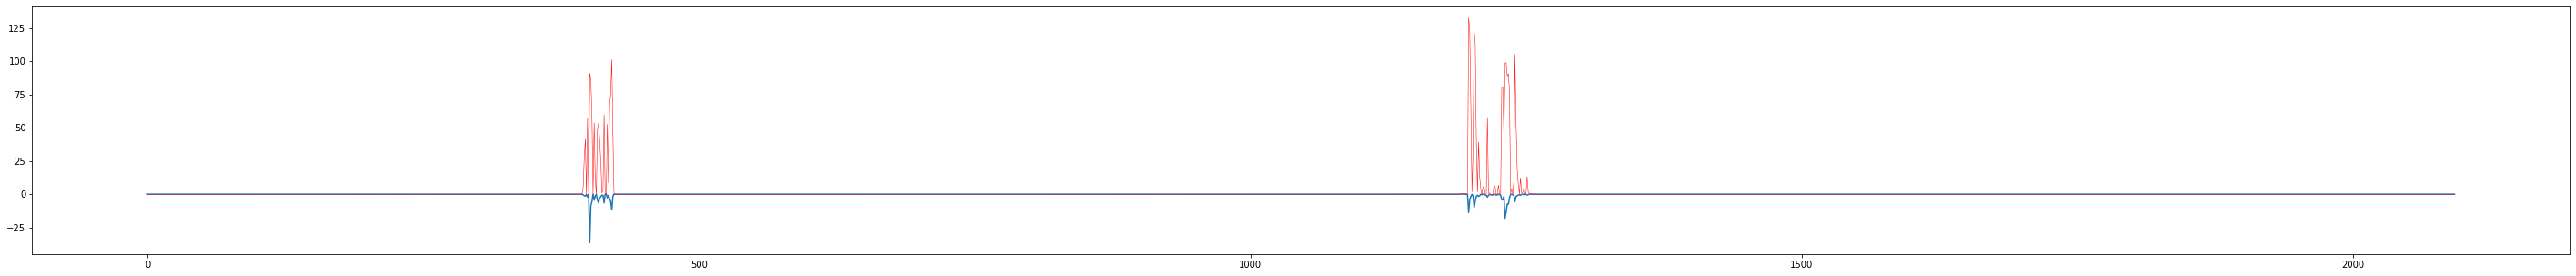

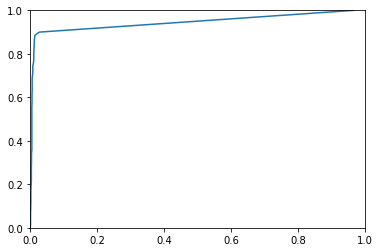

AUC:  0.9116033035287694


0.9116033035287694

In [0]:
ocsvm = OneClassSVM_AnomalyDetection.from_DataFrame(df,30,0.7,0.3)
ocsvm.fit()
ocsvm.plot()
ocsvm.get_roc_auc(verbose=False)

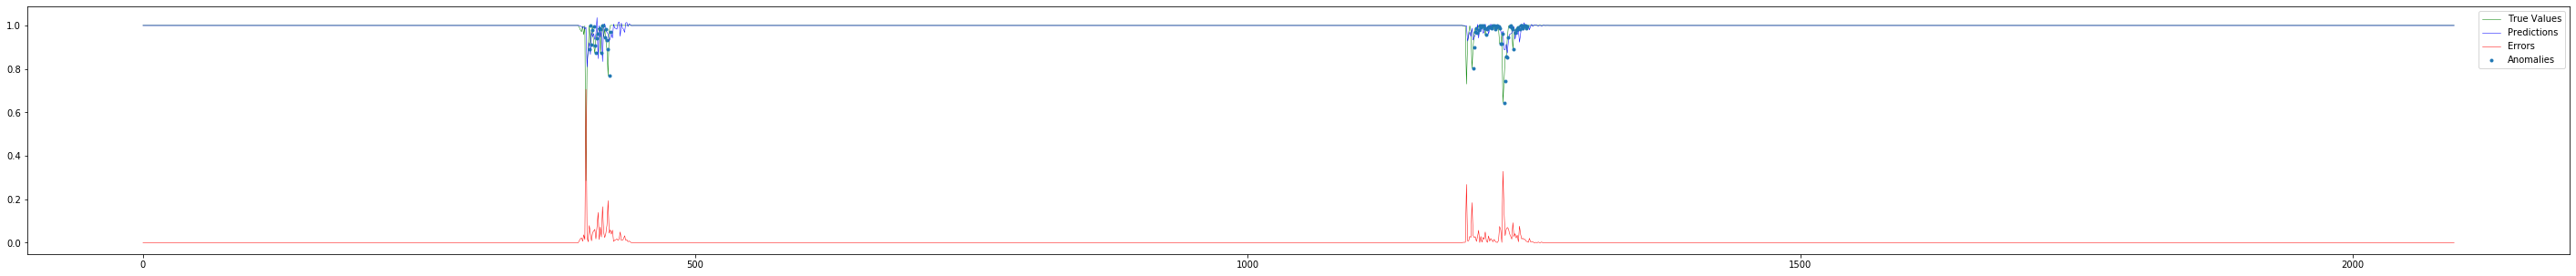

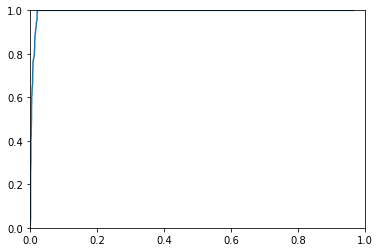

AUC:  0.960169954269333


0.960169954269333

In [0]:
ar_model = AR_Compact.from_DataFrame(df,0.3)
# ar_model = AR_Compact('drive/My Drive/MT/Experiments/Univariate/YahooServiceNetworkTraffic/A4Benchmark/A4Benchmark-TS18.csv', 0.3)
ar_model.fit()
ar_model.predict()
ar_model.plot()
ar_model.get_roc_auc(verbose=False)

# Projection

In [0]:
import warnings
from sklearn.cluster import KMeans
from statsmodels.tsa.ar_model import AR
from sklearn.metrics import mean_squared_error
from math import sqrt
from pandas import read_csv
import pandas as pd
from pandas import DataFrame
from pandas import concat
import numpy as np 
from matplotlib import pyplot
from xgboost import XGBRegressor
from sklearn import preprocessing
import sys
from tensorflow import set_random_seed
set_random_seed(42)
from numpy.random import seed
import numpy
import matplotlib.pyplot as plt
import pandas
import math
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error
import numpy as np
from keras.layers import Conv1D,MaxPooling1D,Flatten
seed(42)
from keras import regularizers

def warn(*args, **kwargs):
    pass
    
class Projection_AnomalyDetection:

    @classmethod
    def from_DataFrame(cls,dataframe,window_width, dimension, train_rate) -> 'Projection_AnomalyDetection':
    	return cls(dataframe, window_width, dimension, train_rate)

    @classmethod
    def from_file(cls, path, window_width, dimension, train_rate) -> 'Projection_AnomalyDetection':
    	df = read_csv(path, header=0, index_col=None, parse_dates=True,squeeze=True)
    	return cls(df,window_width, dimension, train_rate)
         
    # def __init__(self,path, window_width, dimension, train_rate):

    #     self.dimension = dimension
    #     self.n_epochs = n_epochs
    #     self.window_width = window_width
        
    #     self.n_filters = n_filters
    #     self.kernel_size = kernel_size
    #     self.n_dense = n_dense

    #     self.df = read_csv(path, header=0, index_col=None, parse_dates=True,squeeze=True)
    #     self.df = self.df.reset_index(drop=True)
    #     self.df.rename(columns={'Target':'is_anomaly'}, inplace=True)
    #     self.df.loc[self.df.is_anomaly == "'Anomaly'", 'is_anomaly'] = 1
    #     self.df.loc[self.df.is_anomaly == "'Normal'", 'is_anomaly'] = 0
        
    #     self.X_origin = self.df.iloc[:,:dimension].values
    #     self.Y_origin = self.df.iloc[:,-1].values

    #     df_sensors = pd.DataFrame(self.df.iloc[:,:dimension].values)  
    #     self.values = df_sensors
    #     self.dataframe = concat([self.df.iloc[:,:-1].shift(1), self.df.iloc[:,:-1], self.df.iloc[:,-1]], axis=1)
    #     self.dataframe.columns = np.r_[np.array(['V'+str(i)+'_t' for i in range(1,10)]),np.array(['V'+str(i)+'_t+1' for i in range(1,10)]),['is_anomaly']]

    #     # self.dataframe = concat([self.values.shift(1), self.values], axis=1)
    #     # self.dataframe.columns = ['t', 't+1']

    #     self.train_size = int(len(self.values) * train_rate)  

    def __init__(self,dataframe, window_width, dimension, train_rate):

        self.df = dataframe
        self.dimension = dimension
        self.window_width = window_width
        self.df = self.df.reset_index(drop=True)
        self.df.rename(columns={'Target':'is_anomaly'}, inplace=True)
        self.df.loc[self.df.is_anomaly == "'Anomaly'", 'is_anomaly'] = 1
        self.df.loc[self.df.is_anomaly == "'Normal'", 'is_anomaly'] = 0

        self.X_origin = self.df.iloc[:,:dimension].values
        self.Y_origin = self.df.iloc[:,-1].values

        df_sensors = pd.DataFrame(self.df.iloc[:,:dimension].values)  
        self.values = df_sensors
        self.dataframe = concat([self.df.iloc[:,:-1].shift(1), self.df.iloc[:,:-1], self.df.iloc[:,-1]], axis=1)
        self.dataframe.columns = np.r_[np.array(['V'+str(i)+'_t' for i in range(1,self.dimension+1)]),np.array(['V'+str(i)+'_t+1' for i in range(1,self.dimension+1)]),['is_anomaly']]



        # self.train_size = int(len(self.values) * train_rate)   

    def reset_dataframe(self, dataframe, dimension, window_width, train_rate):
        self.df = ddataframef
        self.dimension = dimension
        self.window_width = window_width
        self.df = self.df.reset_index(drop=True)
        self.df.rename(columns={'Target':'is_anomaly'}, inplace=True)
        self.df.loc[self.df.is_anomaly == "'Anomaly'", 'is_anomaly'] = 1
        self.df.loc[self.df.is_anomaly == "'Normal'", 'is_anomaly'] = 0

        df_sensors = pd.DataFrame(self.df.iloc[:,:dimension].values)  
        self.values = df_sensors
        self.dataframe = concat([self.df.iloc[:,:-1].shift(1), self.df.iloc[:,:-1], self.df.iloc[:,-1]], axis=1)
        self.dataframe.columns = np.r_[np.array(['V'+str(i)+'_t' for i in range(1,self.dimension+1)]),np.array(['V'+str(i)+'_t+1' for i in range(1,self.dimension+1)]),['is_anomaly']]



        self.train_size = int(len(self.values) * train_rate)   

    def create_XY_lookback_dataset(self,dataset, look_back=1):
        dataX, dataY = [], []
        for i in range(len(dataset)-look_back-1):
            a = dataset[i:(i+look_back),:self.dimension]
            dataX.append(a)
            dataY.append(dataset[i + look_back,:self.dimension].reshape(-1))
        return numpy.array(dataX), numpy.array(dataY)
    
    def getWindowedVectors(self, X):
        vectors = np.zeros((len(X) - self.window_width+1,self.window_width))
        for i,_ in enumerate(X[:-self.window_width+1]):
            vectors[i] = X[i:i+self.window_width]
        return vectors




    def build_sets(self):

        self.X = self.dataframe.iloc[:,:-1].values
        self.Y = self.dataframe.iloc[:,-1].values
        self.train, self.test = X[1:self.train_size], X[self.train_size:]    
        # print('Train.len:',len(self.train),' - Test.len:', len(self.test))

        self.train_X, self.train_y = self.create_XY_lookback_dataset(self.train, self.window_width)
        self.test_X, self.test_y = self.create_XY_lookback_dataset(self.test, self.window_width)
        # print('TrainX.shape:',self.train_X.shape,' - TestX.shape:', self.test_X.shape,' - TrainY.shape:', self.train_y.shape,' - TestY.shape:', self.test_y.shape)

        self.validationsize = int(self.train_X.shape[0] * 0.1)
        self.val, self.test = self.test[:self.validationsize], self.test[self.validationsize:]
        self.val_X, self.val_y= self.test_X[:self.validationsize], self.test_y[:self.validationsize]
        self.test_X, self.test_y = self.test_X[self.validationsize:], self.test_y[self.validationsize:]
        
    def standardize_dataframe(self):

        self.scalar = preprocessing.StandardScaler().fit(X)
        self.X = self.scalar.transform(X)
        self.dataframe = pd.DataFrame(np.concatenate((X,self.dataframe.values[:,-1].reshape(-1,1)),axis=1))
        self.dataframe.columns = np.r_[np.array(['V'+str(i)+'_t' for i in range(1,self.dimension+1)]),np.array(['V'+str(i)+'_t+1' for i in range(1,self.dimension+1)]),['is_anomaly']]

    def inverse_standardize_dataframe(self):
        X = self.dataframe.values[:,:-1]
        X = self.scalar.inverse_transform(X)
        self.dataframe = pd.DataFrame(np.concatenate((X,self.dataframe.values[:,-1].reshape(-1,1)),axis=1))
        self.dataframe.columns = np.r_[np.array(['V'+str(i)+'_t' for i in range(1,self.dimension+1)]),np.array(['V'+str(i)+'_t+1' for i in range(1,self.dimension+1)]),['is_anomaly']]



    def model_persistence(self, x):
        return x
        
    def create_persistence(self):
        rmse = sqrt(mean_squared_error(self.dataframe.iloc[self.train_size:,:self.dimension], self.dataframe.iloc[self.train_size:,self.dimension:-1]))
        # print('Persistent Model RMSE: %.3f' % rmse)   

    def fit(self):
        self.create_persistence()
        self.standardize_dataframe()
        self.build_sets()
                
        self.compute_anomalyScores()
        self.inverse_standardize_dataframe()
        self.compute_Errors_RMSE()


    def plotTraining(self):
        history_dict = self.history.history
        loss_values = history_dict['loss'][1:]
        val_loss_values = history_dict['val_loss'][1:]
        self.n_epochs = range(2, self.n_epochs + 1)
        plt.plot(self.n_epochs, loss_values, 'bo', label='Training loss')
        plt.plot(self.n_epochs, val_loss_values, 'b', label='Validation loss')
        plt.title('Training and validation loss')
        plt.xlabel('Epochs')
        plt.ylabel('Loss')
        plt.legend()
        plt.show()

    def getchange(self, V_0,V_1):
        Matrix = V_1.T@V_0@V_0.T@V_1
        eigenvalues = np.linalg.eig(Matrix)[0]
        lambda_min = np.min(eigenvalues)
        return np.sqrt(max((1-lambda_min),0))
        
    def get_projected_Dataframe(self):
        changes_anomaly = np.empty((len(self.X_origin)-self.window_width-1,2))
        for i in range(len(self.X_origin)-self.window_width-1):
            W_0 = self.X_origin[i:i+self.window_width]
            W_1 = self.X_origin[i+1:i+self.window_width+1]
            changes_anomaly[i] = [self.getchange(W_0,W_1),self.Y_origin[i]]         
        return pd.DataFrame(changes_anomaly)

    def compute_anomalyScores(self):

        changes_anomaly = np.empty((len(self.train_X)-self.window_width-1,1))
        for i in range(len(self.X)-window_width-1):
            W_0 = self.X[i:i+window_width]
            W_1 = self.X[i+1:i+window_width+1]
            changes_anomaly[i] = [getchange(W_0,W_1),self.Y[i]]    

        # self.train_X = numpy.reshape(self.train_X, (self.train_X.shape[0],self.dimension,self.train_X.shape[1]))
        # self.test_X = numpy.reshape(self.test_X, (self.test_X.shape[0],self.dimension, self.test_X.shape[1]))

        from keras.layers import Conv1D,MaxPooling1D,Flatten
        self.model = Sequential()

        self.model = Sequential()
        self.model.add(LSTM(self.n_filters[0], batch_input_shape=(1, self.window_width, self.dimension), stateful=True, return_sequences=True))
        self.model.add(LSTM(self.n_filters[1], batch_input_shape=(1, self.window_width, self.dimension), stateful=True))
        self.model.add(Dense(self.dimension))
        self.model.compile(optimizer='adam', loss='mse')
        for i in range(self.n_epochs):
            sys.stdout.write('\r'+str(i)+':'+str(self.n_epochs))
            self.model.fit(self.train_X, self.train_y,validation_data=(self.val_X,self.val_y), epochs=1, batch_size=1, verbose=0, shuffle=False)
            self.model.reset_states()
        print('')

        # self.plotTraining()
        self.predictions = self.model.predict(self.test_X, batch_size = 1)


    def compute_Errors_RMSE(self):

        rmse = sqrt(mean_squared_error(self.test_y.reshape(self.predictions.shape), self.predictions))
        self.errors = np.absolute(self.test_y.reshape(self.predictions.shape) - np.array(self.predictions))
        # print('Prediction Test RMS        E: %.3f' % rmse)       
   

    def plot(self):
        fig, axes = plt.subplots(nrows=3, ncols=3, dpi=120, figsize=(50,5))
        for i, ax in enumerate(axes.flatten()):
            data = self.df[self.df.columns[i]].iloc[:200]
            ax.plot(self.test_y[:,i], color='green',  linewidth=0.5,label='True Values')
            ax.plot(self.predictions[:,i], color='blue',  linewidth=0.5,label='Predictions')
            ax.plot(self.errors[:,i], color = 'red',  linewidth=0.5, label='Errors')
            ax.legend()
            
        plt.show()

    def get_roc_auc(self, plot=True, verbose=True):
        self.euclidean_errors = numpy.linalg.norm(self.test_y.reshape(self.predictions.shape) - self.predictions, axis=1)
        # get the predicted errors of the anomaly points
        indices = self.df[self.df['is_anomaly']==1].index >self.train_size + self.validationsize
        true_anomaly_predicted_errors = self.euclidean_errors[self.df[self.df['is_anomaly']==1].index[indices] - self.train_size - self.validationsize - self.window_width -1]
        if len(true_anomaly_predicted_errors) == 0:
            return np.nan
        # sort them 
        true_anomaly_predicted_errors = np.sort(true_anomaly_predicted_errors,axis=0).reshape(-1)
        true_anomaly_predicted_errors_extended = np.r_[np.linspace(0,true_anomaly_predicted_errors[0],40)[:-1],true_anomaly_predicted_errors]
        true_anomaly_predicted_errors_extended = np.r_[true_anomaly_predicted_errors_extended, true_anomaly_predicted_errors_extended[-1] + np.mean(true_anomaly_predicted_errors_extended)]
                # now iterate thru the predicted errors from small to big
        # for each value look how much other points have equal or bigger error
        FPR = [] # fp/n  https://en.wikipedia.org/wiki/Sensitivity_and_specificity
        TPR = [] # tp/p
        p = len(true_anomaly_predicted_errors)
        Thresholds = []
        for predictederror in true_anomaly_predicted_errors_extended:
            threshold = predictederror
            tp = len(true_anomaly_predicted_errors[true_anomaly_predicted_errors>= threshold])
            fp = len(self.euclidean_errors[self.euclidean_errors>=threshold])-len(true_anomaly_predicted_errors[true_anomaly_predicted_errors>=threshold])
            
            fpr =fp/len(self.euclidean_errors)
            FPR.append(fpr)
            TPR.append(tp/p)
            if verbose:
                print("Threshold: {0:25}  - FP: {1:4} - TP: {2:4} - FPR: {3:21} - TPR: {4:4}".format(threshold,fp, tp, fpr, tp/p))

        import matplotlib.pyplot as plt
        if plot:
            plt.figure()
            plt.axis([0, 1, 0, 1])
            plt.plot(FPR,TPR)
            plt.show() 

        # This is the AUC
        from sklearn.metrics import auc
        print('AUC: ' ,auc(FPR,TPR)        )
        return auc(FPR,TPR)

# filters = [[8,8,8,8], [4,4,4,4], [4,8,16,32], [16,32,48,64],  [32,64,12,24],[128,128,128,128],[64,64,64,64],[256,256,256,256],[128,256,512,1024]]
# kernelsizes = [2,3,4,6,8,16]
# dense = [18,36,72,144]

# best_auc = [0,0]
# histories = []
# for f in filters:
#     for k in kernelsizes:
#         for d in dense:

#             cnn = WaveNet_AnomalyDetection('drive/My Drive/MT/Experiments/Multivariate/NASA_Shuttle/40902.csv',30,9,20,0.3,f,k,d)
#             hist = cnn.fit()
#             histories.append(((f,k,d), hist))
#             # cnn.plot()
#             auc = cnn.get_roc_auc(verbose=False,plot=False)
#             print(' auc:', auc, ' - f:', f, ' - k:', k, ' - d:', d)
#             if best_auc[1] < auc:
#                 print('New best auc:', auc, ' - f:', f, ' - k:', k, ' - d:', d)
#                 best_auc = [(f,k,d),auc]

# filters = [[8,8,8,8], [4,4,4,4], [4,8,16,32], [16,32,48,64],  [32,64,12,24],[128,128,128,128],[64,64,64,64],[256,256,256,256],[128,256,512,1024]]
# kernelsizes = [2,3,4,6,8,16]
# dense = [18,36,72,144]


# for epochs in [50,60,70,80,100,150,200]:
#     # cnn = LSTM_AnomalyDetection('drive/My Drive/MT/Experiments/Multivariate/NASA_Shuttle/40902.csv',30,9,20,0.3,[4,4],k,d)
#     cnn = LSTM_AnomalyDetection(dataframe=df,window_width=13,dimension=5,n_epochs=epochs,train_rate=0.3,n_filters=[7,7])
#     # cnn.reset_dataframe(df,5,13, 0.3)
#     cnn.fit()
#     # # cnn.plot()
#     auc = cnn.get_roc_auc(verbose=False,plot=True)
#     print(best_auc)
#     # 0.59 40 EPochs

## Evaluation with SD Results (Synthetic Data)

In [0]:
import datetime
startTime = datetime.datetime.now()
cl = Projection_AnomalyDetection.from_DataFrame(df_synthetic,10,5,0.3)
df_projected = cl.get_projected_Dataframe()
df_projected.columns = ['V1','is_anomaly']
endTime = datetime.datetime.now()
diff = endTime - startTime
print('Time: ',diff.seconds)

Time:  0


### AR

In [0]:
import datetime
startTime = datetime.datetime.now()

ar_model = AR_Compact.from_DataFrame(df_projected,0.3)
ar_model.fit()
ar_model.predict()
ar_model.get_roc_auc(verbose=False,plot=False)

endTime = datetime.datetime.now()
diff = endTime - startTime
print('Time: ',diff.microseconds/1000, 'ms')

AUC:  0.9542249675790048
Time:  205.158 ms


### MA

In [0]:
import datetime
startTime = datetime.datetime.now()

ma = MA.from_DataFrame(df_projected,0.3)
ma.fit()
ma.predict()
ma.get_roc_auc(verbose=False,plot=False)

endTime = datetime.datetime.now()
diff = endTime - startTime
print('Time: ',diff.microseconds/1000, 'ms')

AUC:  0.9611698860146064
Time:  75.569 ms


### ARIMA

2092:2093


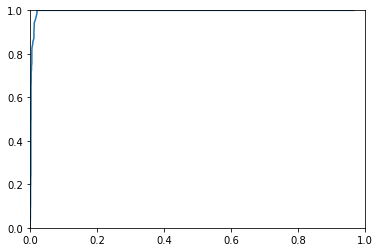

0.9622107705958638
Time:  689.741 ms


In [0]:
import datetime
startTime = datetime.datetime.now()

arima_model = ARIMA_Compact.from_DataFrame(df,0.3, (1,0,2))
arima_model.fit()
arima_model.predict()
auc = arima_model.get_roc_auc(verbose=False)
print(auc)
endTime = datetime.datetime.now()
diff = endTime - startTime
print('Time: ',diff.microseconds/1000, 'ms')

2092:2093


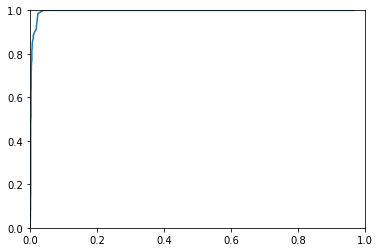

0.9617671148727049
Time:  345.399 ms


In [0]:
import datetime
startTime = datetime.datetime.now()

arima_model = ARIMA_Compact.from_DataFrame(df,0.3, (2,0,1))
arima_model.fit()
arima_model.predict()
auc = arima_model.get_roc_auc(verbose=False)
print(auc)
endTime = datetime.datetime.now()
diff = endTime - startTime
print('Time: ',diff.microseconds/1000, 'ms')

2092:2093


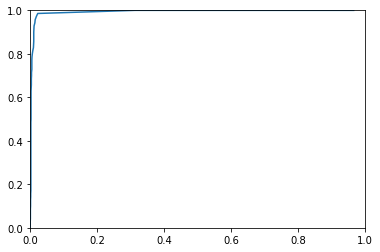

0.9597331240188384
Time:  40.906 ms


In [0]:
import datetime
startTime = datetime.datetime.now()

arima_model = ARIMA_Compact.from_DataFrame(df,0.3, (1,0,3))
arima_model.fit()
arima_model.predict()
auc = arima_model.get_roc_auc(verbose=False)
print(auc)
endTime = datetime.datetime.now()
diff = endTime - startTime
print('Time: ',diff.microseconds/1000, 'ms')

2092:2093


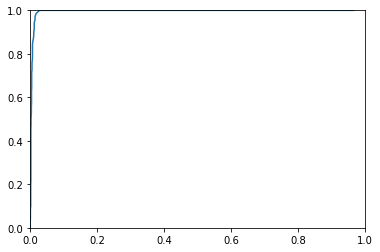

0.961760289400041
Time:  477.123 ms


In [0]:
import datetime
startTime = datetime.datetime.now()

arima_model = ARIMA_Compact.from_DataFrame(df,0.3, (3,0,1))
arima_model.fit()
arima_model.predict()
auc = arima_model.get_roc_auc(verbose=False)
print(auc)
endTime = datetime.datetime.now()
diff = endTime - startTime
print('Time: ',diff.microseconds/1000, 'ms')

2092:2093


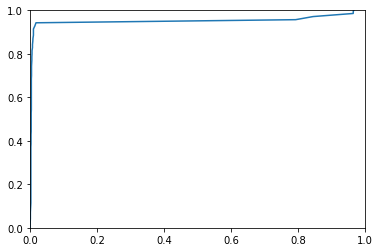

0.9186642549996588
Time:  65.954 ms


In [0]:
import datetime
startTime = datetime.datetime.now()

arima_model = ARIMA_Compact.from_DataFrame(df,0.3, (2,0,3))
arima_model.fit()
arima_model.predict()
auc = arima_model.get_roc_auc(verbose=False)
print(auc)
endTime = datetime.datetime.now()
diff = endTime - startTime
print('Time: ',diff.microseconds/1000, 'ms')

2092:2093


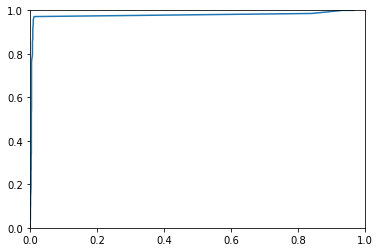

0.9437171524128045
Time:  347.623 ms


In [0]:
import datetime
startTime = datetime.datetime.now()

arima_model = ARIMA_Compact.from_DataFrame(df,0.3, (3,0,2))
arima_model.fit()
arima_model.predict()
auc = arima_model.get_roc_auc(verbose=False)
print(auc)
endTime = datetime.datetime.now()
diff = endTime - startTime
print('Time: ',diff.microseconds/1000, 'ms')

### OCSVM

In [0]:
import datetime
startTime = datetime.datetime.now()

ocsvm = OneClassSVM_AnomalyDetection.from_DataFrame(df_projected,60,0.8,0.3)
ocsvm.fit()
ocsvm.get_roc_auc(verbose=False,plot=False)

endTime = datetime.datetime.now()
diff = endTime - startTime
print('Time: ',diff.microseconds/1000, 'ms')

2033:2033AUC:  0.9524230427957135
Time:  506.724 ms


### XGBoost

In [0]:
import datetime
startTime = datetime.datetime.now()

xbg = XGBRegressor_AnomalyDetection.from_DataFrame(df_projected,30,0.3)
xbg.fit()
xbg.get_roc_auc(verbose=False,plot=False)

endTime = datetime.datetime.now()
diff = endTime - startTime
print('Time: ',diff.microseconds/1000, 'ms')

[01:48:55] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
AUC:  0.9557606989284009
Time:  41.665 ms


# PCI

## Evaluation with SD Results (Synthetic data)

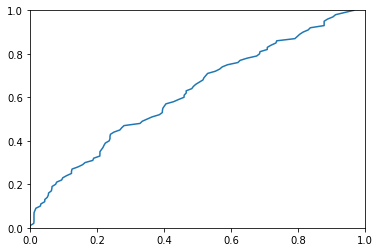

AUC:  0.5883750000000001
Time:  232.261 ms


In [0]:
import numpy as np
import statistics
import math
import matplotlib.pyplot as plt
import scipy.stats
import ipywidgets as widgets
import pandas as pd
from datetime import datetime
import matplotlib.pyplot as plt
from pandas import read_csv
from tqdm import tqdm_notebook, tnrange
from matplotlib import pyplot


class PCI:

    @classmethod
    def from_DataFrame(cls,dataframe,window_width, dimension) -> 'PCI':
    	return cls(dataframe, dimension, window_width)

    @classmethod
    def from_file(cls, path, index_col, window_width, dimension) -> 'PCI':
    	df = read_csv(path, header=0, index_col=index_col, parse_dates=True,squeeze=True)
    	return cls(df, dimension, window_width)
     
    def __init__(self,dataframe, dimension, window_width):
        self.window_width = window_width
        self.dimension = dimension

        self.df = dataframe
        self.df = self.df.reset_index(drop=True)
        self.df.rename(columns={'anomaly':'is_anomaly'}, inplace=True)
        self.df.loc[self.df.is_anomaly == "'Anomaly'", 'is_anomaly'] = 1
        self.df.loc[self.df.is_anomaly == "'Normal'", 'is_anomaly'] = 0

        self.X_origin = self.df.iloc[:,:dimension].values
        self.Y_origin = self.df.iloc[:,-1].values

        # split into train and test sets

        df_sensors = pd.DataFrame(self.df.iloc[:,:dimension].values)  
        self.values = df_sensors

        series = self.df.iloc[:,0]
        self.X = series.values

        self.test = self.X

    def getWindow_Mean(self, sqlResult, row_index, column_index, window_width):
        '''
        sqlResult: The data from mysql database starting with the timestamp field
        row_index: The record we want to analyze if it contains anomalies
        column_index: the field in the sqlresult we want to analyze for the currenct record
        window_width: the amount of data we bundle to compute mean and std 
        This function gets all the data that are window_width * 0.5 before and after the current data point and 
        then it computes the std and mean of it. Then it looks if they are more than 3*std away from the mean
        '''
        lst_field = []
        lst_timestamp = []
        for counter,x in enumerate(sqlResult):
            lst_field.append(x)
            lst_timestamp.append(counter)

        index_begin = max(0,int(row_index-window_width/2))
        index_end = min(len(lst_field),int(row_index+window_width/2))-1
        sliced_lst_field = lst_field[index_begin:index_end]
        sliced_lst_timestamp = lst_timestamp[index_begin:index_end]
        mean=statistics.mean(sliced_lst_field)
        std = statistics.stdev(sliced_lst_field)
        lst_ad_field = []
        lst_ad_timestamp = []
        lst_ad_timestamp_range = []
        for counter,elem in enumerate(sliced_lst_field):
            if abs(elem - mean) > 3*(std):
                lst_ad_field.append(elem)
                lst_ad_timestamp.append(sliced_lst_timestamp[counter])
                lst_ad_timestamp_range.append((lst_timestamp[index_begin],lst_timestamp[index_end-1]))
        return lst_ad_timestamp,lst_ad_field, set(lst_ad_timestamp_range)

    def getWindowedAnomalies(self, sql_result,show_range=False):
        '''
        sqlResult: The data from mysql database starting with the timestamp field
        window_width: the amount of data we bundle to compute mean and std 
        show_range: If anomlay is detected for a data point, it marks the range of data that has been analyzed gray
        This functions iterates over the whole data in sql_result and detects anomalies that have a value more than 3*std away from mean
        it only analyzed this data for the second field in sql_result. The first field must contain the timestamp
        '''
        glb_lst_ad_timestamp, glb_lst_ad_field, glb_lst_ad_range_begin, glb_lst_ad_range_end = [],[], [],[]
        lst_timestamp = []
        lst_field = []
        sliced_sqlResult = []
        for counter, row in enumerate(sql_result):
            lst_timestamp.append(counter)
            lst_field.append(row)

            lst_ad_timestamp, lst_ad_field, lst_ad_range = self.getWindow_Mean(sql_result,counter,1,self.window_width)
            glb_lst_ad_timestamp += lst_ad_timestamp
            glb_lst_ad_field += lst_ad_field
            if show_range:
                for ad_range in lst_ad_range:
                    glb_lst_ad_range_begin.append(ad_range[0])
                    glb_lst_ad_range_end.append(ad_range[1])

        plt.figure(figsize=(18,5))
        plt.plot(lst_timestamp, lst_field)

        for counter,_ in enumerate(glb_lst_ad_range_begin):
            plt.axvspan(glb_lst_ad_range_begin[counter], glb_lst_ad_range_end[counter], color='gray', alpha=0.1)

        plt.plot(glb_lst_ad_timestamp, glb_lst_ad_field, linestyle="",marker=".")
        plt.show()

    def calculatePCI(self, sql_result,index, k, BothSidedWindow= True):
        '''
        sqlResult: The data from mysql database starting with the timestamp field
        index: The record we want to analyze if it contains anomalies
        k: the k parameter from the paper
        BothSideWindow: if true we look left and right of the datapoint, otherwise just left of the datapoint 
        This function implements completely the algorith proposed in the mentioned paper. Instead of using Students t-Test
        I implemented a similar approach using Z-table of normal distribution
        '''
        lst_values = []
        start = 0
        end = 0
        if BothSidedWindow:
            start =max(0,index-k)
            end = min(len(sql_result), index+k)-1
        else:
            start = max(0,index - 2*k)
            end = min(len(sql_result),index)
        v_i_zaehler = 0
        v_i_nenner = 0
        for counter,i in enumerate(range(start,end )):
            if i == index:
                continue
            lst_values.append(sql_result[i])
            w = 0
            if i<index:
                w = counter+1
            else:
                w = 2*k - counter 
            v_i_zaehler += sql_result[i]*w
            v_i_nenner +=w
        # if we cannot predict, just return the value
        if v_i_zaehler == 0 or len(lst_values)<2: 
            return (sql_result[index]-1,sql_result[index]+1)
        
        v_index = v_i_zaehler/v_i_nenner
        std = statistics.stdev(lst_values)

        t_student=0
        # the higher k the closer z to 0.5 - max = 120
        # 0.5 + ((120-min(k,120))/120)*0.4999999999
        percentile = 0.5 + ((120-min(k,120))/120)*0.4999999999
        z = scipy.stats.norm.ppf(percentile)
        delta = z * std* np.sqrt(1+1/2*k)
        PCI = (v_index - delta,v_index+delta)
        return PCI

    def plotAnomaliesByPCI(self, sql_result, plot = True):
        '''
        sqlResult: The data from mysql database starting with the timestamp field
        Calculate Anomalies by PCI as described in the paper and plot it
        '''
        lst_timestamp = []
        lst_field = []
        lst_PCI_up = []
        lst_PCI_down = []
        lst_ad_timestamp =[]
        lst_ad_value = []
        self.lst_anomalyScores = []
        for counter, row in enumerate(sql_result):
            PCI = self.calculatePCI(sql_result,counter,self.window_width,True)
            lst_timestamp.append(counter)
            lst_field.append(row)
            lst_PCI_up.append(PCI[1])
            lst_PCI_down.append(PCI[0])
            if PCI[0]!=0:
                self.lst_anomalyScores.append(abs(row/PCI[0]))
            else:
                self.lst_anomalyScores.append(min(2,row))

            if row>PCI[1] or row<PCI[0]:
                lst_ad_value.append(row)
                lst_ad_timestamp.append(counter)
        if plot:
            plt.figure(figsize=(50,5))
            plt.plot(lst_timestamp, lst_field, color='green',  linewidth=0.5,label='True Values')
            plt.plot(self.lst_anomalyScores, color = 'red',  linewidth=0.5, label='Errors')
            plt.plot(lst_timestamp, lst_PCI_up, color = 'gray',  linewidth=0.5, label='Upper bound')
            plt.plot(lst_timestamp, lst_PCI_down, color = 'gray',  linewidth=0.5, label='lower bound')
            plt.plot(lst_ad_timestamp, lst_ad_value, linestyle="",marker=".", label='Anomalies')
            pyplot.legend()
            plt.show()    


        self.errors = np.array(self.lst_anomalyScores)


    def getAndReadAnaomaliesByPCI(self, plot = True):
        myresult = self.test
        self.plotAnomaliesByPCI(myresult, plot)
        # self.getWindowedAnomalies(myresult,show_range=True)

    def get_roc_auc(self, plot=True, verbose=True):
        # get the predicted errors of the anomaly points
        indices = self.df[self.df['is_anomaly']==1].index
        true_anomaly_predicted_errors = self.errors[self.df[self.df['is_anomaly']==1].index]
        if len(true_anomaly_predicted_errors) == 0:
            return np.nan

        # sort them 
        true_anomaly_predicted_errors = np.sort(true_anomaly_predicted_errors,axis=0).reshape(-1)
        true_anomaly_predicted_errors_extended = np.r_[np.linspace(0,true_anomaly_predicted_errors[0],40)[:-1],true_anomaly_predicted_errors]
        true_anomaly_predicted_errors_extended = np.r_[true_anomaly_predicted_errors_extended, true_anomaly_predicted_errors_extended[-1] + np.mean(true_anomaly_predicted_errors_extended)]
                # now iterate thru the predicted errors from small to big
        # for each value look how much other points have equal or bigger error
        FPR = [] # fp/n  https://en.wikipedia.org/wiki/Sensitivity_and_specificity
        TPR = [] # tp/p
        p = len(true_anomaly_predicted_errors)
        Thresholds = []
        for predictederror in true_anomaly_predicted_errors_extended:
            threshold = predictederror
            tp = len(true_anomaly_predicted_errors[true_anomaly_predicted_errors>= threshold])
            fp = len(self.errors[self.errors>=threshold])-len(true_anomaly_predicted_errors[true_anomaly_predicted_errors>=threshold])
            
            fpr =fp/len(self.errors)
            FPR.append(fpr)
            TPR.append(tp/p)
            if verbose:
                print("Threshold: {0:25}  - FP: {1:4} - TP: {2:4} - FPR: {3:21} - TPR: {4:4}".format(threshold,fp, tp, fpr, tp/p))

        import matplotlib.pyplot as plt
        if plot:
            plt.figure()
            plt.axis([0, 1, 0, 1])
            plt.plot(FPR,TPR)
            plt.show() 

        # This is the AUC
        from sklearn.metrics import auc
        print('AUC: ' ,auc(FPR,TPR)        )
        return auc(FPR,TPR)

def concatenate_errors(pci_univariates):
    pci_ = pci_univariates[0]
    errors = np.zeros((len(pci_.errors),dimension))
    errors[:,0] = pci_.errors.T
    # for i in range(1,5):
    for i in range(1,5):
        errors[:,0:i+1] = np.c_[errors[:,:i],pci_univariates[i].errors.reshape(-1,1)]
    return np.min(errors,axis=1)

import datetime
startTime = datetime.datetime.now()

dimension = 5
# df = read_csv(path, header=0, index_col=index_col, parse_dates=True,squeeze=True)
pci_univariates = []
for i in range (5):
    df_univariate = pd.DataFrame(np.c_[df_synthetic.iloc[:,i].values,df_synthetic.iloc[:,-1].values])
    df_univariate.columns = ['V1','is_anomaly']
    pci = PCI.from_DataFrame(df_univariate,1,30)
    pci.getAndReadAnaomaliesByPCI(plot=False)
    pci_univariates.append(pci)
	
errors = concatenate_errors(pci_univariates)
pci_full = PCI.from_DataFrame(df_synthetic,5,30)
pci_full.errors = errors
pci_full.get_roc_auc(verbose=False)

endTime = datetime.datetime.now()
diff = endTime - startTime
print('Time: ',diff.microseconds/1000, 'ms')

In [0]:
pci_full.errors[pci_full.df[pci_full.df['is_anomaly']==1].index]

array([ 3.57606601,  0.88997972,  9.74379388,  2.34622533,  2.39294193,
        5.38675185,  1.69721882,  1.16054171,  0.7862683 ,  5.30511495,
        3.78908175,  1.75813109,  1.55104757,  3.92613851,  1.09750602,
        1.29405852,  2.40319974,  0.80715273,  0.85976198,  1.21974377,
       38.60791286,  5.96962031,  0.61098272,  2.14028132,  0.57356381,
        1.0640279 ,  0.80469045,  0.39014012,  4.09908444,  1.67672936,
        0.86416203,  1.26864304,  1.38328373,  2.05430778,  0.53661442,
        0.90148382,  0.67353149,  1.4981974 ,  1.44883605,  0.82064085,
        1.19433493,  5.70129488,  0.59133117,  0.90129703,  1.13245097,
        0.82006299,  1.36447617,  2.63734726,  1.16863943,  2.02741321,
        1.9650796 ,  9.62090989,  2.57594567,  0.90022881,  1.01710797,
        2.80727874, 22.47050111,  0.95337636,  3.40293926,  3.31260149,
        2.93503245,  0.49720037,  0.75962195,  0.58928331,  1.52733869,
        1.20576384,  1.39101067,  0.76720972,  1.0222843 ,  3.29

/usr/local/lib/python3.6/dist-packages/pandas/core/ops/__init__.py:1115: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  result = method(y)


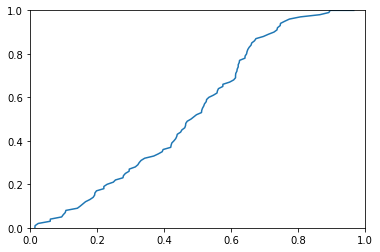

AUC:  0.5097266666666667


0.5097266666666667

In [0]:
errors.shape

(3000,)

In [0]:
errors.shape

(2100, 5)

In [0]:
pci_univariates

In [0]:
np.c_[errors[:,:1],pci_univariates[i].errors.reshape(-1,1)]

array([[ 6.33296665,  0.0553428 ],
       [ 0.02314365,  0.53213001],
       [ 0.24789135,  0.40936552],
       ...,
       [ 5.96778369,  2.58301956],
       [ 1.93090272,  0.32807892],
       [ 0.53276044, 17.49954775]])

In [0]:
errors

array([[6.33296665, 0.        , 0.        , 0.        , 0.        ],
       [0.02314365, 0.        , 0.        , 0.        , 0.        ],
       [0.24789135, 0.        , 0.        , 0.        , 0.        ],
       ...,
       [5.96778369, 0.        , 0.        , 0.        , 0.        ],
       [1.93090272, 0.        , 0.        , 0.        , 0.        ],
       [0.53276044, 0.        , 0.        , 0.        , 0.        ]])

# VAR Model

In [0]:
import scipy.linalg
from scipy.spatial import distance
import warnings
from statsmodels.tsa.ar_model import AR
from sklearn.metrics import mean_squared_error
from math import sqrt
from pandas import read_csv
import pandas as pd
from pandas import DataFrame
from pandas import concat
import numpy as np 
from matplotlib import pyplot
from sklearn import preprocessing
import sys
from tensorflow import set_random_seed
set_random_seed(42)
from numpy.random import seed
import numpy
import matplotlib.pyplot as plt
import pandas
import math
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error
import numpy as np
seed(42)
from statsmodels.tsa.api import VAR, DynamicVAR

def warn(*args, **kwargs):
    pass
    
class VAR_AnomalyDetection:

    @classmethod
    def from_DataFrame(cls,dataframe,window_width, dimension, train_rate, distance_function) -> 'Projection_AnomalyDetection':
    	return cls(dataframe, window_width, dimension, train_rate, distance_function)

    @classmethod
    def from_file(cls, path, window_width, dimension, train_rate, distance_function) -> 'Projection_AnomalyDetection':
    	df = read_csv(path, header=0, index_col=None, parse_dates=True,squeeze=True)
    	return cls(df,window_width, dimension, train_rate, distance_function)
         
    # def __init__(self,path, window_width, dimension, train_rate):

    #     self.dimension = dimension
    #     self.n_epochs = n_epochs
    #     self.window_width = window_width
        
    #     self.n_filters = n_filters
    #     self.kernel_size = kernel_size
    #     self.n_dense = n_dense

    #     self.df = read_csv(path, header=0, index_col=None, parse_dates=True,squeeze=True)
    #     self.df = self.df.reset_index(drop=True)
    #     self.df.rename(columns={'Target':'is_anomaly'}, inplace=True)
    #     self.df.loc[self.df.is_anomaly == "'Anomaly'", 'is_anomaly'] = 1
    #     self.df.loc[self.df.is_anomaly == "'Normal'", 'is_anomaly'] = 0
        
    #     self.X_origin = self.df.iloc[:,:dimension].values
    #     self.Y_origin = self.df.iloc[:,-1].values

    #     df_sensors = pd.DataFrame(self.df.iloc[:,:dimension].values)  
    #     self.values = df_sensors
    #     self.dataframe = concat([self.df.iloc[:,:-1].shift(1), self.df.iloc[:,:-1], self.df.iloc[:,-1]], axis=1)
    #     self.dataframe.columns = np.r_[np.array(['V'+str(i)+'_t' for i in range(1,10)]),np.array(['V'+str(i)+'_t+1' for i in range(1,10)]),['is_anomaly']]

    #     # self.dataframe = concat([self.values.shift(1), self.values], axis=1)
    #     # self.dataframe.columns = ['t', 't+1']

    #     self.train_size = int(len(self.values) * train_rate)  

    def __init__(self,dataframe, window_width, dimension, train_rate, distance_function):

        self.df = dataframe
        self.dimension = dimension
        self.window_width = window_width
        self.df = self.df.reset_index(drop=True)
        self.df.rename(columns={'Target':'is_anomaly'}, inplace=True)
        self.df.loc[self.df.is_anomaly == "'Anomaly'", 'is_anomaly'] = 1
        self.df.loc[self.df.is_anomaly == "'Normal'", 'is_anomaly'] = 0
        self.distance_function = distance_function
        self.X_origin = self.df.iloc[:,:dimension].values
        self.Y_origin = self.df.iloc[:,-1].values

        df_sensors = pd.DataFrame(self.df.iloc[:,:dimension].values)  
        self.values = df_sensors
        self.dataframe = concat([self.df.iloc[:,:-1].shift(1), self.df.iloc[:,:-1], self.df.iloc[:,-1]], axis=1)
        self.dataframe.columns = np.r_[np.array(['V'+str(i)+'_t' for i in range(1,self.dimension+1)]),np.array(['V'+str(i)+'_t+1' for i in range(1,self.dimension+1)]),['is_anomaly']]
        self.train_size = int(len(self.values) * train_rate)   
 

    def create_XY_lookback_dataset(self,dataset, look_back=1):
        dataX, dataY = [], []
        for i in range(len(dataset)-look_back-1):
            a = dataset[i:(i+look_back),:self.dimension]
            dataX.append(a)
            dataY.append(dataset[i + look_back,:self.dimension].reshape(-1))
        return numpy.array(dataX), numpy.array(dataY)
    
    def getWindowedVectors(self, X):
        vectors = np.zeros((len(X) - self.window_width+1,self.window_width))
        for i,_ in enumerate(X[:-self.window_width+1]):
            vectors[i] = X[i:i+self.window_width]
        return vectors




    def build_sets(self):

        self.X = self.dataframe.iloc[:,:-1].values
        self.Y = self.dataframe.iloc[:,-1].values
        self.train, self.test = self.X[1:self.train_size], self.X[self.train_size:]    
        # print('Train.len:',len(self.train),' - Test.len:', len(self.test))

        self.train_X, self.train_y = self.train[:,:self.dimension], self.train[:,self.dimension: -1]
        self.test_X, self.test_y = self.test[:,:self.dimension], self.test[:,self.dimension: -1]
        # print('TrainX.shape:',self.train_X.shape,' - TestX.shape:', self.test_X.shape,' - TrainY.shape:', self.train_y.shape,' - TestY.shape:', self.test_y.shape)

        # self.validationsize = int(self.train_X.shape[0] * 0.1)
        # self.val, self.test = self.test[:self.validationsize], self.test[self.validationsize:]
        # self.val_X, self.val_y= self.test_X[:self.validationsize], self.test_y[:self.validationsize]
        # self.test_X, self.test_y = self.test_X[self.validationsize:], self.test_y[self.validationsize:]
        
    def standardize_dataframe(self):
        X = self.dataframe.values[:,:-1]
        self.scalar = preprocessing.StandardScaler().fit(X)
        X = self.scalar.transform(X)
        self.dataframe = pd.DataFrame(np.concatenate((X,self.dataframe.values[:,-1].reshape(-1,1)),axis=1))
        self.dataframe.columns = np.r_[np.array(['V'+str(i)+'_t' for i in range(1,self.dimension+1)]),np.array(['V'+str(i)+'_t+1' for i in range(1,self.dimension+1)]),['is_anomaly']]

    def inverse_standardize_dataframe(self):
        X = self.dataframe.values[:,:-1]
        X = self.scalar.inverse_transform(X)
        self.dataframe = pd.DataFrame(np.concatenate((X,self.dataframe.values[:,-1].reshape(-1,1)),axis=1))
        self.dataframe.columns = np.r_[np.array(['V'+str(i)+'_t' for i in range(1,self.dimension+1)]),np.array(['V'+str(i)+'_t+1' for i in range(1,self.dimension+1)]),['is_anomaly']]



    def model_persistence(self, x):
        return x
        
    def create_persistence(self):
        rmse = sqrt(mean_squared_error(self.dataframe.iloc[self.train_size:,:self.dimension], self.dataframe.iloc[self.train_size:,self.dimension:-1]))
        # print('Persistent Model RMSE: %.3f' % rmse)   

    def fit(self):
        self.standardize_dataframe()
        self.create_persistence()
        self.build_sets()
                
        self.compute_anomalyScores()

        self.compute_Errors_RMSE()
        self.inverse_standardize_dataframe()

    def compute_anomalyScores(self, verbose=False):
        self.model = VAR(self.train_X)
        self.model_fit = self.model.fit(self.window_width)
        self.window = self.model_fit.k_ar
        self.coef = self.model_fit.params  
        # if verbose:      
        #     print('Lag: %s' % self.model_fit.k_ar)
        #     print('Coefficients: %s' % self.model_fit.params)
        self.history = self.train_X[len(self.train_X)-self.window:]
        self.history = [self.history[i] for i in range(len(self.history))]
        self.predictions = list()
        for t in range(len(self.test_X)):
            length = len(self.history)
            lag = [self.history[i] for i in range(length-self.window,length)]
            self.yhat = self.model_fit.forecast(lag,1)
            # yhat = self.coef[0]
            # for d in range(self.window):
            #     yhat += self.coef[d+1] * lag[self.window-d-1]
            obs = self.test_X[t]
            self.predictions.append(self.yhat[0])
            self.history.append(obs)        
        # for i in range(len(predictions)):
        #     print('predicted=%f, expected=%f' % (predictions[i], test[i]))
        # rmse = sqrt(mean_squared_error(self.test, self.predictions))
        self.error_vect = np.absolute(self.test_X - np.array(self.predictions))
        # Calculate Mahalonbis distance 
        self.compute_errors(self.distance_function)


    def compute_errors(self, distance_function):
        if distance_function == 'mahalanobis':
            inv_cov = scipy.linalg.inv(np.cov(self.error_vect.T))
            mean = np.mean(self.error_vect,axis=0)
            self.errors = np.zeros((len(self.error_vect),1))
            for i,error in enumerate(self.error_vect):
                self.errors[i] = distance.mahalanobis(error,mean,inv_cov)
        elif distance_function == 'euclidean':
            inv_cov = scipy.linalg.inv(np.cov(self.error_vect.T))
            mean = np.mean(self.error_vect,axis=0)
            self.errors = np.zeros((len(self.error_vect),1))
            for i,error in enumerate(self.error_vect):
                self.errors[i] = distance.euclidean(error,mean)
                
    def plotTraining(self):
        history_dict = self.history.history
        loss_values = history_dict['loss'][1:]
        val_loss_values = history_dict['val_loss'][1:]
        self.n_epochs = range(2, self.n_epochs + 1)
        plt.plot(self.n_epochs, loss_values, 'bo', label='Training loss')
        plt.plot(self.n_epochs, val_loss_values, 'b', label='Validation loss')
        plt.title('Training and validation loss')
        plt.xlabel('Epochs')
        plt.ylabel('Loss')
        plt.legend()
        plt.show()

    def getchange(self, V_0,V_1):
        Matrix = V_1.T@V_0@V_0.T@V_1
        eigenvalues = np.linalg.eig(Matrix)[0]
        lambda_min = np.min(eigenvalues)
        return np.sqrt(max((1-lambda_min),0))
        
    def get_projected_Dataframe(self):
        changes_anomaly = np.empty((len(self.X_origin)-self.window_width-1,2))
        for i in range(len(self.X_origin)-self.window_width-1):
            W_0 = self.X_origin[i:i+self.window_width]
            W_1 = self.X_origin[i+1:i+self.window_width+1]
            changes_anomaly[i] = [self.getchange(W_0,W_1),self.Y_origin[i]]         
        return pd.DataFrame(changes_anomaly)



    def compute_Errors_RMSE(self):

        rmse = sqrt(mean_squared_error(self.test_y.reshape(self.predictions.shape), self.predictions))
        self.errors = np.absolute(self.test_y.reshape(self.predictions.shape) - np.array(self.predictions))
        # print('Prediction Test RMS        E: %.3f' % rmse)       
   

    def plot(self):
        fig, axes = plt.subplots(nrows=3, ncols=3, dpi=120, figsize=(50,5))
        for i, ax in enumerate(axes.flatten()):
            data = self.df[self.df.columns[i]].iloc[:200]
            ax.plot(self.test_y[:,i], color='green',  linewidth=0.5,label='True Values')
            ax.plot(self.predictions[:,i], color='blue',  linewidth=0.5,label='Predictions')
            ax.plot(self.errors[:,i], color = 'red',  linewidth=0.5, label='Errors')
            ax.legend()
            
        plt.show()

    def get_roc_auc(self, plot=True, verbose=True):
        # get the predicted errors of the anomaly points
        indices = self.df[self.df['is_anomaly']==1].index >self.train_size
        true_anomaly_predicted_errors = self.errors[self.df[self.df['is_anomaly']==1].index[indices] - self.train_size - self.window_width -1]
        if len(true_anomaly_predicted_errors) == 0:
            return np.nan
        # sort them 
        true_anomaly_predicted_errors = np.sort(true_anomaly_predicted_errors,axis=0).reshape(-1)
        true_anomaly_predicted_errors_extended = np.r_[np.linspace(0,true_anomaly_predicted_errors[0],40)[:-1],true_anomaly_predicted_errors]
        true_anomaly_predicted_errors_extended = np.r_[true_anomaly_predicted_errors_extended, true_anomaly_predicted_errors_extended[-1] + np.mean(true_anomaly_predicted_errors_extended)]
                # now iterate thru the predicted errors from small to big
        # for each value look how much other points have equal or bigger error
        FPR = [] # fp/n  https://en.wikipedia.org/wiki/Sensitivity_and_specificity
        TPR = [] # tp/p
        p = len(true_anomaly_predicted_errors)
        Thresholds = []
        for predictederror in true_anomaly_predicted_errors_extended:
            threshold = predictederror
            tp = len(true_anomaly_predicted_errors[true_anomaly_predicted_errors>= threshold])
            fp = len(self.errors[self.errors>=threshold])-len(true_anomaly_predicted_errors[true_anomaly_predicted_errors>=threshold])
            
            fpr =fp/len(self.errors)
            FPR.append(fpr)
            TPR.append(tp/p)
            if verbose:
                print("Threshold: {0:25}  - FP: {1:4} - TP: {2:4} - FPR: {3:21} - TPR: {4:4}".format(threshold,fp, tp, fpr, tp/p))

        import matplotlib.pyplot as plt
        if plot:
            plt.figure()
            plt.axis([0, 1, 0, 1])
            plt.plot(FPR,TPR)
            plt.show() 

        # This is the AUC
        from sklearn.metrics import auc
        print('AUC: ' ,auc(FPR,TPR)        )
        return auc(FPR,TPR)

# filters = [[8,8,8,8], [4,4,4,4], [4,8,16,32], [16,32,48,64],  [32,64,12,24],[128,128,128,128],[64,64,64,64],[256,256,256,256],[128,256,512,1024]]
# kernelsizes = [2,3,4,6,8,16]
# dense = [18,36,72,144]

# best_auc = [0,0]
# histories = []
# for f in filters:
#     for k in kernelsizes:
#         for d in dense:

#             cnn = WaveNet_AnomalyDetection('drive/My Drive/MT/Experiments/Multivariate/NASA_Shuttle/40902.csv',30,9,20,0.3,f,k,d)
#             hist = cnn.fit()
#             histories.append(((f,k,d), hist))
#             # cnn.plot()
#             auc = cnn.get_roc_auc(verbose=False,plot=False)
#             print(' auc:', auc, ' - f:', f, ' - k:', k, ' - d:', d)
#             if best_auc[1] < auc:
#                 print('New best auc:', auc, ' - f:', f, ' - k:', k, ' - d:', d)
#                 best_auc = [(f,k,d),auc]

# filters = [[8,8,8,8], [4,4,4,4], [4,8,16,32], [16,32,48,64],  [32,64,12,24],[128,128,128,128],[64,64,64,64],[256,256,256,256],[128,256,512,1024]]
# kernelsizes = [2,3,4,6,8,16]
# dense = [18,36,72,144]


# for epochs in [50,60,70,80,100,150,200]:
#     # cnn = LSTM_AnomalyDetection('drive/My Drive/MT/Experiments/Multivariate/NASA_Shuttle/40902.csv',30,9,20,0.3,[4,4],k,d)
#     cnn = LSTM_AnomalyDetection(dataframe=df,window_width=13,dimension=5,n_epochs=epochs,train_rate=0.3,n_filters=[7,7])
#     # cnn.reset_dataframe(df,5,13, 0.3)
#     cnn.fit()
#     # # cnn.plot()
#     auc = cnn.get_roc_auc(verbose=False,plot=True)
#     print(best_auc)
#     # 0.59 40 EPochs

## Evaluation

### Evaluation with SD Results (Synthetic data)

In [0]:
import datetime
startTime = datetime.datetime.now()
var = VAR_AnomalyDetection.from_DataFrame(df_synthetic,13,5,0.3,'mahalanobis')
var.standardize_dataframe()
var.create_persistence()
var.build_sets()
var.compute_anomalyScores()
auc =var.get_roc_auc(verbose=False,plot=False)

endTime = datetime.datetime.now()
diff = endTime - startTime
print(diff.microseconds/1000)

AUC:  0.5632585034013605
198.259


In [0]:
import datetime
startTime = datetime.datetime.now()
var = VAR_AnomalyDetection.from_file('drive/My Drive/MT/Experiments/Multivariate/NASA_Shuttle/40903.csv',2,3,0.3,'mahalanobis')
var.standardize_dataframe()
var.create_persistence()
var.build_sets()
var.compute_anomalyScores()
auc =var.get_roc_auc(verbose=False,plot=False)

endTime = datetime.datetime.now()
diff = endTime - startTime
print(diff.microseconds/1000)

AUC:  0.8669780250713105
409.008


In [0]:

var = VAR_AnomalyDetection.from_file('drive/My Drive/MT/Experiments/Multivariate/NASA_Shuttle/40902.csv',13,9,0.1,'mahalanobis')
var.standardize_dataframe()
var.create_persistence()
var.build_sets()
var.compute_anomalyScores()
auc =var.get_roc_auc(verbose=False,plot=False)

AUC:  0.47143157569699823


In [0]:

var = VAR_AnomalyDetection.from_file('drive/My Drive/MT/Experiments/Multivariate/NASA_Shuttle/40901.csv',13,9,0.1,'mahalanobis')
var.standardize_dataframe()
var.create_persistence()
var.build_sets()
var.compute_anomalyScores()
auc =var.get_roc_auc(verbose=False,plot=False)
print(auc)

nan


# VARMAX Model

In [0]:
import scipy.linalg
from scipy.spatial import distance
import warnings
from statsmodels.tsa.ar_model import AR
from sklearn.metrics import mean_squared_error
from math import sqrt
from pandas import read_csv
import pandas as pd
from pandas import DataFrame
from pandas import concat
import numpy as np 
from matplotlib import pyplot
from sklearn import preprocessing
import sys
from tensorflow import set_random_seed
set_random_seed(42)
from numpy.random import seed
import numpy
import matplotlib.pyplot as plt
import pandas
import math
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error
import numpy as np
seed(42)
from statsmodels.tsa.api import VAR, DynamicVAR
from statsmodels.tsa.statespace.varmax import VARMAX
def warn(*args, **kwargs):
    pass
    
class VARMAX_AnomalyDetection:

    @classmethod
    def from_DataFrame(cls,dataframe,window_width, dimension, train_rate, distance_function) -> 'Projection_AnomalyDetection':
    	return cls(dataframe, window_width, dimension, train_rate, distance_function)

    @classmethod
    def from_file(cls, path, window_width, dimension, train_rate, distance_function) -> 'Projection_AnomalyDetection':
    	df = read_csv(path, header=0, index_col=None, parse_dates=True,squeeze=True)
    	return cls(df,window_width, dimension, train_rate, distance_function)
         
    # def __init__(self,path, window_width, dimension, train_rate):

    #     self.dimension = dimension
    #     self.n_epochs = n_epochs
    #     self.window_width = window_width
        
    #     self.n_filters = n_filters
    #     self.kernel_size = kernel_size
    #     self.n_dense = n_dense

    #     self.df = read_csv(path, header=0, index_col=None, parse_dates=True,squeeze=True)
    #     self.df = self.df.reset_index(drop=True)
    #     self.df.rename(columns={'Target':'is_anomaly'}, inplace=True)
    #     self.df.loc[self.df.is_anomaly == "'Anomaly'", 'is_anomaly'] = 1
    #     self.df.loc[self.df.is_anomaly == "'Normal'", 'is_anomaly'] = 0
        
    #     self.X_origin = self.df.iloc[:,:dimension].values
    #     self.Y_origin = self.df.iloc[:,-1].values

    #     df_sensors = pd.DataFrame(self.df.iloc[:,:dimension].values)  
    #     self.values = df_sensors
    #     self.dataframe = concat([self.df.iloc[:,:-1].shift(1), self.df.iloc[:,:-1], self.df.iloc[:,-1]], axis=1)
    #     self.dataframe.columns = np.r_[np.array(['V'+str(i)+'_t' for i in range(1,10)]),np.array(['V'+str(i)+'_t+1' for i in range(1,10)]),['is_anomaly']]

    #     # self.dataframe = concat([self.values.shift(1), self.values], axis=1)
    #     # self.dataframe.columns = ['t', 't+1']

    #     self.train_size = int(len(self.values) * train_rate)  

    def __init__(self,dataframe, window_width, dimension, train_rate, distance_function):

        self.df = dataframe
        self.dimension = dimension
        self.window_width = window_width
        self.df = self.df.reset_index(drop=True)
        self.df.rename(columns={'Target':'is_anomaly'}, inplace=True)
        self.df.loc[self.df.is_anomaly == "'Anomaly'", 'is_anomaly'] = 1
        self.df.loc[self.df.is_anomaly == "'Normal'", 'is_anomaly'] = 0
        self.distance_function = distance_function
        self.X_origin = self.df.iloc[:,:dimension].values
        self.Y_origin = self.df.iloc[:,-1].values

        df_sensors = pd.DataFrame(self.df.iloc[:,:dimension].values)  
        self.values = df_sensors
        self.dataframe = concat([self.df.iloc[:,:-1].shift(1), self.df.iloc[:,:-1], self.df.iloc[:,-1]], axis=1)
        self.dataframe.columns = np.r_[np.array(['V'+str(i)+'_t' for i in range(1,self.dimension+1)]),np.array(['V'+str(i)+'_t+1' for i in range(1,self.dimension+1)]),['is_anomaly']]
        self.train_size = int(len(self.values) * train_rate)   
 

    def create_XY_lookback_dataset(self,dataset, look_back=1):
        dataX, dataY = [], []
        for i in range(len(dataset)-look_back-1):
            a = dataset[i:(i+look_back),:self.dimension]
            dataX.append(a)
            dataY.append(dataset[i + look_back,:self.dimension].reshape(-1))
        return numpy.array(dataX), numpy.array(dataY)
    
    def getWindowedVectors(self, X):
        vectors = np.zeros((len(X) - self.window_width+1,self.window_width))
        for i,_ in enumerate(X[:-self.window_width+1]):
            vectors[i] = X[i:i+self.window_width]
        return vectors




    def build_sets(self):

        self.X = self.dataframe.iloc[:,:-1].values
        self.Y = self.dataframe.iloc[:,-1].values
        self.train, self.test = self.X[1:self.train_size], self.X[self.train_size:]    
        # print('Train.len:',len(self.train),' - Test.len:', len(self.test))

        self.train_X, self.train_y = self.train[:,:self.dimension], self.train[:,self.dimension: -1]
        self.test_X, self.test_y = self.test[:,:self.dimension], self.test[:,self.dimension: -1]
        # print('TrainX.shape:',self.train_X.shape,' - TestX.shape:', self.test_X.shape,' - TrainY.shape:', self.train_y.shape,' - TestY.shape:', self.test_y.shape)

        # self.validationsize = int(self.train_X.shape[0] * 0.1)
        # self.val, self.test = self.test[:self.validationsize], self.test[self.validationsize:]
        # self.val_X, self.val_y= self.test_X[:self.validationsize], self.test_y[:self.validationsize]
        # self.test_X, self.test_y = self.test_X[self.validationsize:], self.test_y[self.validationsize:]
        
    def standardize_dataframe(self):
        X = self.dataframe.values[:,:-1]
        self.scalar = preprocessing.StandardScaler().fit(X)
        X = self.scalar.transform(X)
        self.dataframe = pd.DataFrame(np.concatenate((X,self.dataframe.values[:,-1].reshape(-1,1)),axis=1))
        self.dataframe.columns = np.r_[np.array(['V'+str(i)+'_t' for i in range(1,self.dimension+1)]),np.array(['V'+str(i)+'_t+1' for i in range(1,self.dimension+1)]),['is_anomaly']]

    def inverse_standardize_dataframe(self):
        X = self.dataframe.values[:,:-1]
        X = self.scalar.inverse_transform(X)
        self.dataframe = pd.DataFrame(np.concatenate((X,self.dataframe.values[:,-1].reshape(-1,1)),axis=1))
        self.dataframe.columns = np.r_[np.array(['V'+str(i)+'_t' for i in range(1,self.dimension+1)]),np.array(['V'+str(i)+'_t+1' for i in range(1,self.dimension+1)]),['is_anomaly']]



    def model_persistence(self, x):
        return x
        
    def create_persistence(self):
        rmse = sqrt(mean_squared_error(self.dataframe.iloc[self.train_size:,:self.dimension], self.dataframe.iloc[self.train_size:,self.dimension:-1]))
        # print('Persistent Model RMSE: %.3f' % rmse)   

    def fit(self):
        self.standardize_dataframe()
        self.create_persistence()
        self.build_sets()
                
        self.compute_anomalyScores()

        self.compute_Errors_RMSE()
        self.inverse_standardize_dataframe()

    def compute_anomalyScores(self, verbose=False):
        # model = VARMAX(data, order=(1, 1))
        # model_fit = model.fit(disp=False)
        # make prediction
        warnings.filterwarnings("ignore")
        self.model = VARMAX(self.train_X, order=(self.window_width,2))
        self.model_fit = self.model.fit(maxiter=100, disp=False)
        # self.model = VAR(self.train_X)
        # self.model_fit = self.model.fit(self.window_width)
        # self.coef = self.model_fit.params  
        # if verbose:      
        #     print('Lag: %s' % self.model_fit.k_ar)
        #     print('Coefficients: %s' % self.model_fit.params)
        self.history = self.train_X[len(self.train_X)-self.window_width:]
        self.history = [self.history[i] for i in range(len(self.history))]
        self.predictions = list()
        print('start')
        for t in range(len(self.test_X)):
            length = len(self.history)
            warnings.filterwarnings("ignore")
            lag = [self.history[i] for i in range(length-self.window_width,length)]
            self.yhat = self.model_fit.forecast(1)

            obs = self.test_X[t]
            self.predictions.append(self.yhat[0])
            self.history.append(obs)        
            sys.stdout.write('\r'+str(t)+':'+str(len(self.test_X)))

        # for i in range(len(predictions)):
        #     print('predicted=%f, expected=%f' % (predictions[i], test[i]))
        # rmse = sqrt(mean_squared_error(self.test, self.predictions))
        self.error_vect = np.absolute(self.test_X - np.array(self.predictions))
        # Calculate Mahalonbis distance 
        self.compute_errors(self.distance_function)


    def compute_errors(self, distance_function):
        if distance_function == 'mahalanobis':
            inv_cov = scipy.linalg.inv(np.cov(self.error_vect.T))
            mean = np.mean(self.error_vect,axis=0)
            self.errors = np.zeros((len(self.error_vect),1))
            for i,error in enumerate(self.error_vect):
                self.errors[i] = distance.mahalanobis(error,mean,inv_cov)
        elif distance_function == 'euclidean':
            inv_cov = scipy.linalg.inv(np.cov(self.error_vect.T))
            mean = np.mean(self.error_vect,axis=0)
            self.errors = np.zeros((len(self.error_vect),1))
            for i,error in enumerate(self.error_vect):
                self.errors[i] = distance.euclidean(error,mean)
                
    def plotTraining(self):
        history_dict = self.history.history
        loss_values = history_dict['loss'][1:]
        val_loss_values = history_dict['val_loss'][1:]
        self.n_epochs = range(2, self.n_epochs + 1)
        plt.plot(self.n_epochs, loss_values, 'bo', label='Training loss')
        plt.plot(self.n_epochs, val_loss_values, 'b', label='Validation loss')
        plt.title('Training and validation loss')
        plt.xlabel('Epochs')
        plt.ylabel('Loss')
        plt.legend()
        plt.show()

    def getchange(self, V_0,V_1):
        Matrix = V_1.T@V_0@V_0.T@V_1
        eigenvalues = np.linalg.eig(Matrix)[0]
        lambda_min = np.min(eigenvalues)
        return np.sqrt(max((1-lambda_min),0))
        
    def get_projected_Dataframe(self):
        changes_anomaly = np.empty((len(self.X_origin)-self.window_width-1,2))
        for i in range(len(self.X_origin)-self.window_width-1):
            W_0 = self.X_origin[i:i+self.window_width]
            W_1 = self.X_origin[i+1:i+self.window_width+1]
            changes_anomaly[i] = [self.getchange(W_0,W_1),self.Y_origin[i]]         
        return pd.DataFrame(changes_anomaly)



    def compute_Errors_RMSE(self):

        rmse = sqrt(mean_squared_error(self.test_y.reshape(self.predictions.shape), self.predictions))
        self.errors = np.absolute(self.test_y.reshape(self.predictions.shape) - np.array(self.predictions))
        # print('Prediction Test RMS        E: %.3f' % rmse)       
   

    def plot(self):
        fig, axes = plt.subplots(nrows=3, ncols=3, dpi=120, figsize=(50,5))
        for i, ax in enumerate(axes.flatten()):
            data = self.df[self.df.columns[i]].iloc[:200]
            ax.plot(self.test_y[:,i], color='green',  linewidth=0.5,label='True Values')
            ax.plot(self.predictions[:,i], color='blue',  linewidth=0.5,label='Predictions')
            ax.plot(self.errors[:,i], color = 'red',  linewidth=0.5, label='Errors')
            ax.legend()
            
        plt.show()

    def get_roc_auc(self, plot=True, verbose=True):
        # get the predicted errors of the anomaly points
        indices = self.df[self.df['is_anomaly']==1].index >self.train_size
        true_anomaly_predicted_errors = self.errors[self.df[self.df['is_anomaly']==1].index[indices] - self.train_size - self.window_width -1]
        if len(true_anomaly_predicted_errors) == 0:
            return np.nan
        # sort them 
        true_anomaly_predicted_errors = np.sort(true_anomaly_predicted_errors,axis=0).reshape(-1)
        true_anomaly_predicted_errors_extended = np.r_[np.linspace(0,true_anomaly_predicted_errors[0],40)[:-1],true_anomaly_predicted_errors]
        true_anomaly_predicted_errors_extended = np.r_[true_anomaly_predicted_errors_extended, true_anomaly_predicted_errors_extended[-1] + np.mean(true_anomaly_predicted_errors_extended)]
                # now iterate thru the predicted errors from small to big
        # for each value look how much other points have equal or bigger error
        FPR = [] # fp/n  https://en.wikipedia.org/wiki/Sensitivity_and_specificity
        TPR = [] # tp/p
        p = len(true_anomaly_predicted_errors)
        Thresholds = []
        for predictederror in true_anomaly_predicted_errors_extended:
            threshold = predictederror
            tp = len(true_anomaly_predicted_errors[true_anomaly_predicted_errors>= threshold])
            fp = len(self.errors[self.errors>=threshold])-len(true_anomaly_predicted_errors[true_anomaly_predicted_errors>=threshold])
            
            fpr =fp/len(self.errors)
            FPR.append(fpr)
            TPR.append(tp/p)
            if verbose:
                print("Threshold: {0:25}  - FP: {1:4} - TP: {2:4} - FPR: {3:21} - TPR: {4:4}".format(threshold,fp, tp, fpr, tp/p))

        import matplotlib.pyplot as plt
        if plot:
            plt.figure()
            plt.axis([0, 1, 0, 1])
            plt.plot(FPR,TPR)
            plt.show() 

        # This is the AUC
        from sklearn.metrics import auc
        print('AUC: ' ,auc(FPR,TPR)        )
        return auc(FPR,TPR)

# filters = [[8,8,8,8], [4,4,4,4], [4,8,16,32], [16,32,48,64],  [32,64,12,24],[128,128,128,128],[64,64,64,64],[256,256,256,256],[128,256,512,1024]]
# kernelsizes = [2,3,4,6,8,16]
# dense = [18,36,72,144]

# best_auc = [0,0]
# histories = []
# for f in filters:
#     for k in kernelsizes:
#         for d in dense:

#             cnn = WaveNet_AnomalyDetection('drive/My Drive/MT/Experiments/Multivariate/NASA_Shuttle/40902.csv',30,9,20,0.3,f,k,d)
#             hist = cnn.fit()
#             histories.append(((f,k,d), hist))
#             # cnn.plot()
#             auc = cnn.get_roc_auc(verbose=False,plot=False)
#             print(' auc:', auc, ' - f:', f, ' - k:', k, ' - d:', d)
#             if best_auc[1] < auc:
#                 print('New best auc:', auc, ' - f:', f, ' - k:', k, ' - d:', d)
#                 best_auc = [(f,k,d),auc]

# filters = [[8,8,8,8], [4,4,4,4], [4,8,16,32], [16,32,48,64],  [32,64,12,24],[128,128,128,128],[64,64,64,64],[256,256,256,256],[128,256,512,1024]]
# kernelsizes = [2,3,4,6,8,16]
# dense = [18,36,72,144]


# for epochs in [50,60,70,80,100,150,200]:
#     # cnn = LSTM_AnomalyDetection('drive/My Drive/MT/Experiments/Multivariate/NASA_Shuttle/40902.csv',30,9,20,0.3,[4,4],k,d)
#     cnn = LSTM_AnomalyDetection(dataframe=df,window_width=13,dimension=5,n_epochs=epochs,train_rate=0.3,n_filters=[7,7])
#     # cnn.reset_dataframe(df,5,13, 0.3)
#     cnn.fit()
#     # # cnn.plot()
#     auc = cnn.get_roc_auc(verbose=False,plot=True)
#     print(best_auc)
#     # 0.59 40 EPochs

##Evaluation

### Evaluation with SD Results (Synthetic data)

In [0]:
import datetime
startTime = datetime.datetime.now()

var = VARMAX_AnomalyDetection.from_DataFrame(df_synthetic,4,5,0.3,'mahalanobis')
var.standardize_dataframe()
var.create_persistence()
var.build_sets()
var.compute_anomalyScores()
auc =var.get_roc_auc(verbose=False,plot=False)


endTime = datetime.datetime.now()
diff = endTime - startTime
print(diff.microseconds/1000)

start
2099:2100AUC:  0.73378231292517
303.127


In [0]:
import datetime
startTime = datetime.datetime.now()

var = VARMAX_AnomalyDetection.from_file('drive/My Drive/MT/Experiments/Multivariate/NASA_Shuttle/40903.csv',4,3,0.3,'mahalanobis')
# var = VAR_AnomalyDetection.from_file('drive/My Drive/MT/Experiments/Multivariate/NASA_Shuttle/40903.csv',2,3,0.3,'mahalanobis')
var.standardize_dataframe()
var.create_persistence()
var.build_sets()
var.compute_anomalyScores()
auc =var.get_roc_auc(verbose=False,plot=False)


endTime = datetime.datetime.now()
diff = endTime - startTime
print(diff.microseconds/1000)

start
4362:66610

In [0]:
import datetime
startTime = datetime.datetime.now()

var = VARMAX_AnomalyDetection.from_DataFrame(df_synthetic,4,5,0.3,'euclidean')
var.standardize_dataframe()
var.create_persistence()
var.build_sets()
var.compute_anomalyScores()
auc =var.get_roc_auc(verbose=False,plot=False)


endTime = datetime.datetime.now()
diff = endTime - startTime
print(diff.microseconds/1000)

In [0]:
import datetime
startTime = datetime.datetime.now()
var = VARMAX_AnomalyDetection.from_file('drive/My Drive/MT/Experiments/Multivariate/NASA_Shuttle/40903.csv',4,3,0.3,'euclidean')

var.standardize_dataframe()
var.create_persistence()
var.build_sets()
var.compute_anomalyScores()
auc =var.get_roc_auc(verbose=False,plot=False)


endTime = datetime.datetime.now()
diff = endTime - startTime
print(diff.microseconds/1000)

# Average AR

In [0]:
from statsmodels.tsa.ar_model import AR
from sklearn.metrics import mean_squared_error
from math import sqrt
from pandas import read_csv
import pandas as pd
from pandas import DataFrame
from pandas import concat
import numpy as np 
from matplotlib import pyplot
import sys

class AR_Compact:

    def model_persistence(self, x):
        return x

    def create_persistence(self):
        predictions = list()
        for x in self.test_X:
            yhat = self.model_persistence(x)
            predictions.append(yhat)
        rmse = sqrt(mean_squared_error(self.test_y, predictions))
        # print('Train shape', self.train_X.shape, ' - Test shape:' , self.test_X.shape)
        # print('Persistent Model RMSE: %.3f' % rmse)     
        

    @classmethod
    def from_DataFrame(cls,dataframe, train_rate) -> 'AR_Compact':
    	return cls(dataframe, train_rate)

    @classmethod
    def from_file(cls, file: str, train_rate) -> 'AR_Compact':
    	df = read_csv(path, header=0, index_col=0, parse_dates=True,squeeze=True)
    	return cls(df, train_rate)

    
    def __init__(self,df, train_rate):
        self.df = df
        self.df = self.df.reset_index(drop=True)
        self.df.rename(columns={'anomaly':'is_anomaly'}, inplace=True)
        self.df.loc[self.df.is_anomaly == "'Anomaly'", 'is_anomaly'] = 1
        self.df.loc[self.df.is_anomaly == "'Normal'", 'is_anomaly'] = 0

        series = pd.DataFrame(self.df.iloc[:,0].values)  
        self.values = DataFrame(series.values)
        self.dataframe = concat([self.values.shift(1), self.values], axis=1)
        self.dataframe.columns = ['t', 't+1']

        self.train_size = int(len(self.values) * train_rate)

        self.train, self.test = self.dataframe.values[1:self.train_size], self.dataframe.values[self.train_size:]
        self.train_X, self.train_y = self.train[:,0], self.train[:,1]
        self.test_X, self.test_y = self.test[:,0], self.test[:,1]     
        # self.create_persistence()

        # X = (self.dataframe['t+1'] - self.dataframe['t']).values
        X = series.values

        self.train, self.test = X[1:self.train_size], X[self.train_size:]

          
    def fit(self, verbose=False):
        self.model = AR(self.train)
        self.model_fit = self.model.fit()
        self.window = self.model_fit.k_ar
        self.coef = self.model_fit.params  
        if verbose:      
            print('Lag: %s' % self.model_fit.k_ar)
            print('Coefficients: %s' % self.model_fit.params)

    
    def predict(self):
        self.history = self.train[len(self.train)-self.window:]
        self.history = [self.history[i] for i in range(len(self.history))]
        self.predictions = list()
        for t in range(len(self.test)):
            length = len(self.history)
            lag = [self.history[i] for i in range(length-self.window,length)]
            yhat = self.coef[0]
            for d in range(self.window):
                yhat += self.coef[d+1] * lag[self.window-d-1]
            obs = self.test[t]
            self.predictions.append(yhat)
            self.history.append(obs)        
        # for i in range(len(predictions)):
        #     print('predicted=%f, expected=%f' % (predictions[i], test[i]))
        # rmse = sqrt(mean_squared_error(self.test, self.predictions))
        self.errors = np.absolute(self.test - np.array(self.predictions))
        # print('Prediction Test RMSE: %.3f' % rmse)
    def plot(self):
        # plot predicted error
        df_test = pd.DataFrame(self.df.iloc[self.train_size:].values)

        pyplot.figure(figsize=(50,5))
        pyplot.plot(self.test,color ='blue', linewidth=0.5)
        pyplot.plot(self.predictions, color='green',  linewidth=0.5)
        pyplot.plot(self.errors, color = 'red',  linewidth=0.5)
        pyplot.plot(df_test[df_test[1]==1.].index, df_test[df_test[1]==1.].iloc[:,0].values,'ro')
        pyplot.show()

    # def plot(self):
    #     # plot predicted error
    #     indices = self.df[self.df['is_anomaly']==1].index >self.train_size
    #     pyplot.figure(figsize=(50,5))
    #     pyplot.plot(self.test, color='green',  linewidth=0.5,label='True Values')
    #     pyplot.plot(self.predictions, color='blue',  linewidth=0.5,label='Predictions')
    #     pyplot.plot(self.errors, color = 'red',  linewidth=0.5, label='Errors')
    #     pyplot.plot(self.df[self.df['is_anomaly']==1].index[indices] - self.train_size, self.test[self.df[self.df['is_anomaly']==1].index[indices] - self.train_size -1], linestyle="",marker=".", label='Anomalies')
    #     pyplot.legend()
    #     pyplot.show()

    def get_roc_auc(self, plot=True, verbose=True):
        # get the predicted errors of the anomaly points
        indices = self.df[self.df['is_anomaly']==1].index >self.train_size
        true_anomaly_predicted_errors = self.errors[self.df[self.df['is_anomaly']==1].index[indices] - self.train_size]
        if len(true_anomaly_predicted_errors) == 0:
            return np.nan
        # sort them 
        true_anomaly_predicted_errors = np.sort(true_anomaly_predicted_errors,axis=0).reshape(-1)
        true_anomaly_predicted_errors_extended = np.r_[np.linspace(0,true_anomaly_predicted_errors[0],40)[:-1],true_anomaly_predicted_errors]
        true_anomaly_predicted_errors_extended = np.r_[true_anomaly_predicted_errors_extended, max(true_anomaly_predicted_errors_extended[-1] + np.mean(true_anomaly_predicted_errors_extended),np.max(self.errors) + np.mean(self.errors))]
                # now iterate thru the predicted errors from small to big
        # for each value look how much other points have equal or bigger error
        FPR = [] # fp/n  https://en.wikipedia.org/wiki/Sensitivity_and_specificity
        TPR = [] # tp/p
        p = len(true_anomaly_predicted_errors)
        Thresholds = []
        for predictederror in true_anomaly_predicted_errors_extended:
            threshold = predictederror
            tp = len(true_anomaly_predicted_errors[true_anomaly_predicted_errors>= threshold])
            fp = len(self.errors[self.errors>=threshold])-len(true_anomaly_predicted_errors[true_anomaly_predicted_errors>=threshold])
            
            fpr =fp/len(self.errors)
            FPR.append(fpr)
            TPR.append(tp/p)
            if verbose:
                print("Threshold: {0:25}  - FP: {1:4} - TP: {2:4} - FPR: {3:21} - TPR: {4:4}".format(threshold,fp, tp, fpr, tp/p))

        import matplotlib.pyplot as plt
        if plot:
            plt.figure()
            plt.axis([0, 1, 0, 1])
            plt.plot(FPR,TPR)
            plt.show() 

        # This is the AUC
        from sklearn.metrics import auc
        print('AUC: ' ,auc(FPR,TPR)        )
        return auc(FPR,TPR)

# ar_model = AR_Compact('drive/My Drive/MT/Experiments/Univariate/YahooServiceNetworkTraffic/A4Benchmark/A4Benchmark-TS18.csv', 0.3)
# ar_model.fit()
# ar_model.predict()
# ar_model.plot()
# ar_model.get_roc_auc(verbose=True)

def concatenate_errors(ar_univariates):
    pci_ = ar_univariates[0]
    errors = np.zeros((len(pci_.errors),dimension))
    errors[:,0] = pci_.errors.T
    # for i in range(1,5):
    for i in range(1,5):
        errors[:,0:i+1] = np.c_[errors[:,:i],ar_univariates[i].errors.reshape(-1,1)]
    return np.min(errors,axis=1)


## Evaluation

### Evaluation with SD Results (Synthetic data)

In [0]:

import datetime
startTime = datetime.datetime.now()

dimension = 5
# df = read_csv(path, header=0, index_col=index_col, parse_dates=True,squeeze=True)
ar_univariates = []
for i in range (5):
    print(i)
    df_univariate = pd.DataFrame(np.c_[df_synthetic.iloc[:,i].values,df_synthetic.iloc[:,-1].values])
    df_univariate.columns = ['V1','is_anomaly']
    ar = AR_Compact.from_DataFrame(df_univariate,0.3)
    # ar.getAndReadAnaomaliesByPCI(plot=False)
    ar.fit()
    ar.predict()
    ar_univariates.append(ar)
	
errors = concatenate_errors(ar_univariates)
ar_full = AR_Compact.from_DataFrame(df_synthetic,0.3)
ar_full.errors = errors
ar_full.get_roc_auc(verbose=False)

endTime = datetime.datetime.now()
diff = endTime - startTime
print('Time: ',diff.microseconds/1000, 'ms')

0


NameError: ignored

# Average MA

## Evaluation with SD Results (Synthetic data)

0
1
2
3
4


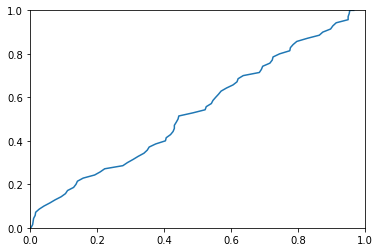

AUC:  0.5047142857142859
Time:  558.662 ms


In [0]:
from statsmodels.tsa.ar_model import AR
from sklearn.metrics import mean_squared_error
from math import sqrt
from pandas import read_csv
import pandas as pd
from pandas import DataFrame
from pandas import concat
import numpy as np 
from matplotlib import pyplot
import sys

class MA_Average:

    @classmethod
    def from_DataFrame(cls,dataframe, train_rate) -> 'MA':
    	return cls(dataframe, train_rate)

    @classmethod
    def from_file(cls, file: str, train_rate) -> 'MA':
    	df = read_csv(path, header=0, index_col=0, parse_dates=True,squeeze=True)
    	return cls(df, train_rate)

    
    def __init__(self,df, train_rate):
        self.df = df
        self.df = self.df.reset_index(drop=True)
        self.df.rename(columns={'anomaly':'is_anomaly'}, inplace=True)
        self.df.loc[self.df.is_anomaly == "'Anomaly'", 'is_anomaly'] = 1
        self.df.loc[self.df.is_anomaly == "'Normal'", 'is_anomaly'] = 0

        series = pd.DataFrame(self.df.iloc[:,0].values)  
        self.values = DataFrame(series.values)
        self.dataframe = concat([self.values.shift(1), self.values], axis=1)
        self.dataframe.columns = ['t', 't+1']

        X = self.dataframe.values
        self.train_size = int(len(X) * train_rate)

        self.train, self.test = self.dataframe.values[1:self.train_size], self.dataframe.values[self.train_size:]
        self.train_X, self.train_y = self.train[:,0], self.train[:,1]
        self.test_X, self.test_y = self.test[:,0], self.test[:,1]     
        # self.create_persistence()

        # X = (self.dataframe['t+1'] - self.dataframe['t']).values
        X = series.values

        # persistence model on training set
        self.train_pred = [x for x in self.train_X]
        # calculate residuals
        self.train_resid = [self.train_y[i]-self.train_pred[i] for i in range(len(self.train_pred))]

    # def __init__(self, path, train_rate):

    #     self.df = read_csv(path, header=0, index_col=0, parse_dates=True,squeeze=True)
    #     self.df = self.df.reset_index(drop=True)
    #     self.df.rename(columns={'anomaly':'is_anomaly'}, inplace=True)
    #     series = pd.DataFrame(self.df.iloc[:,0].values)  
    #     self.values = DataFrame(series.values)
    #     self.dataframe = concat([self.values.shift(1), self.values], axis=1)
    #     self.dataframe.columns = ['t', 't+1']
    #     X = self.dataframe.values

    #     self.train_size = int(len(X) * train_rate)    

    #     train, test = X[1:self.train_size], X[self.train_size:]
    #     self.train_X, self.train_y = train[:,0], train[:,1]
    #     self.test_X, self.test_y = test[:,0], test[:,1]        
    #     # persistence model on training set
    #     self.train_pred = [x for x in self.train_X]
    #     # calculate residuals
    #     self.train_resid = [self.train_y[i]-self.train_pred[i] for i in range(len(self.train_pred))]

    def fit(self, verbose=False):
        self.model = AR(self.train_resid)
        self.model_fit = self.model.fit()
        self.window = self.model_fit.k_ar
        self.coef = self.model_fit.params        
        if verbose:
            print(self.coef)

    def predict(self):
        # walk forward over time steps in test
        self.history = self.train_resid[len(self.train_resid)-self.window:]
        self.history = [self.history[i] for i in range(len(self.history))]
        self.predictions = list()
        for t in range(len(self.test_y)):
            # persistence
            yhat = self.test_X[t]
            error = self.test_y[t] - yhat
            # predict error
            length = len(self.history)
            lag = [self.history[i] for i in range(length-self.window,length)]
            pred_error = self.coef[0]
            for d in range(self.window):
                pred_error += self.coef[d+1] * lag[self.window-d-1]
            # correct the prediction
            yhat = yhat + pred_error
            self.predictions.append(yhat)
            self.history.append(error)
            # print('predicted=%f, expected=%f' % (yhat, test_y[t]))
        rmse = sqrt(mean_squared_error(self.test_y, self.predictions))
        self.errors = np.absolute(self.test_y - np.array(self.predictions))
        # print('Prediction Test RMSE: %.3f' % rmse)

    def plot(self):
        # plot predicted error
        df_test = pd.DataFrame(self.df.iloc[self.train_size:].values)

        pyplot.figure(figsize=(50,5))
        pyplot.plot(self.test_y,color ='blue', linewidth=0.5)
        pyplot.plot(self.predictions, color='green',  linewidth=0.5)
        pyplot.plot(self.errors, color = 'red',  linewidth=0.5)
        pyplot.plot(df_test[df_test[1]==1.].index, df_test[df_test[1]==1.].iloc[:,0].values,'ro')
        pyplot.show()


    def get_roc_auc(self, plot=True, verbose=True):
        # get the predicted errors of the anomaly points
        indices = self.df[self.df['is_anomaly']==1].index >self.train_size
        true_anomaly_predicted_errors = self.errors[self.df[self.df['is_anomaly']==1].index[indices] - self.train_size ]
        if len(true_anomaly_predicted_errors) == 0:
            return np.nan
        # true_anomaly_predicted_errors = self.errors[self.df[self.df['is_anomaly']==1].index - self.train_size ]
        # sort them 
        true_anomaly_predicted_errors = np.sort(true_anomaly_predicted_errors,axis=0).reshape(-1)
        true_anomaly_predicted_errors_extended = np.r_[np.linspace(0,true_anomaly_predicted_errors[0],40)[:-1],true_anomaly_predicted_errors]
        true_anomaly_predicted_errors_extended = np.r_[true_anomaly_predicted_errors_extended, true_anomaly_predicted_errors_extended[-1] + np.mean(true_anomaly_predicted_errors_extended)]
                # now iterate thru the predicted errors from small to big
        # for each value look how much other points have equal or bigger error
        FPR = [] # fp/n  https://en.wikipedia.org/wiki/Sensitivity_and_specificity
        TPR = [] # tp/p
        p = len(true_anomaly_predicted_errors)
        Thresholds = []
        for predictederror in true_anomaly_predicted_errors_extended:
            threshold = predictederror
            tp = len(true_anomaly_predicted_errors[true_anomaly_predicted_errors>= threshold])
            fp = len(self.errors[self.errors>=threshold])-len(true_anomaly_predicted_errors[true_anomaly_predicted_errors>=threshold])
            
            fpr =fp/len(self.errors)
            FPR.append(fpr)
            TPR.append(tp/p)
            if verbose:
                print("Threshold: {0:25}  - FP: {1:4} - TP: {2:4} - FPR: {3:21} - TPR: {4:4}".format(threshold,fp, tp, fpr, tp/p))

        import matplotlib.pyplot as plt
        if plot:
            plt.figure()
            plt.axis([0, 1, 0, 1])
            plt.plot(FPR,TPR)
            plt.show() 

        # This is the AUC
        from sklearn.metrics import auc
        print('AUC: ' ,auc(FPR,TPR)        )
        return auc(FPR,TPR)


# ar_model = AR_Compact('drive/My Drive/MT/Experiments/Univariate/YahooServiceNetworkTraffic/A4Benchmark/A4Benchmark-TS18.csv', 0.3)
# ar_model.fit()
# ar_model.predict()
# ar_model.plot()
# ar_model.get_roc_auc(verbose=True)

def concatenate_errors(ar_univariates):
    pci_ = ar_univariates[0]
    errors = np.zeros((len(pci_.errors),dimension))
    errors[:,0] = pci_.errors.T
    # for i in range(1,5):
    for i in range(1,5):
        errors[:,0:i+1] = np.c_[errors[:,:i],ar_univariates[i].errors.reshape(-1,1)]
    return np.min(errors,axis=1)

import datetime
startTime = datetime.datetime.now()

dimension = 5
# df = read_csv(path, header=0, index_col=index_col, parse_dates=True,squeeze=True)
ar_univariates = []
for i in range (5):
    print(i)
    df_univariate = pd.DataFrame(np.c_[df_synthetic.iloc[:,i].values,df_synthetic.iloc[:,-1].values])
    df_univariate.columns = ['V1','is_anomaly']
    ar = MA_Average.from_DataFrame(df_univariate,0.3)
    # ar.getAndReadAnaomaliesByPCI(plot=False)
    ar.fit()
    ar.predict()
    ar_univariates.append(ar)
	
errors = concatenate_errors(ar_univariates)
ar_full = MA_Average.from_DataFrame(df_synthetic,0.3)
ar_full.errors = errors
ar_full.get_roc_auc(verbose=False)

endTime = datetime.datetime.now()
diff = endTime - startTime
print('Time: ',diff.microseconds/1000, 'ms')

# Average XGBoost

## Evaluation with SD Results (Synthetic data)

0
[13:57:57] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
1
[13:57:57] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
2
[13:57:57] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
3
[13:57:57] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
4
[13:57:57] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


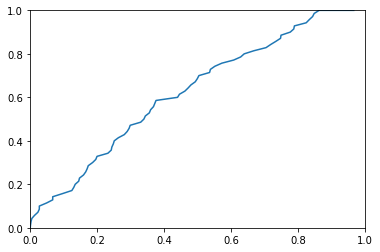

AUC:  0.5930816326530614
Time:  373.552 ms


In [0]:
import warnings
from sklearn.cluster import KMeans
from statsmodels.tsa.ar_model import AR
from sklearn.metrics import mean_squared_error
from math import sqrt
from pandas import read_csv
import pandas as pd
from pandas import DataFrame
from pandas import concat
import numpy as np 
from matplotlib import pyplot
from xgboost import XGBRegressor
from sklearn import preprocessing
import sys

class XGBRegressor_Average_AnomalyDetection:

    @classmethod
    def from_DataFrame(cls,dataframe,window_width, train_rate) -> 'XGBRegressor_AnomalyDetection':
    	return cls(dataframe, window_width, train_rate)

    @classmethod
    def from_file(cls, path, window_width, train_rate) -> 'XGBRegressor_AnomalyDetection':
    	df = read_csv(path, header=0, index_col=0, parse_dates=True,squeeze=True)
    	return cls(df,window_width, train_rate)
         
    def __init__(self,df, window_width, train_rate):
        self.df = df
        self.df = self.df.reset_index(drop=True)
        self.df.rename(columns={'anomaly':'is_anomaly'}, inplace=True)
        self.window_width = window_width
        series = pd.DataFrame(self.df.iloc[:,0].values)  
        self.values = DataFrame(series.values)
        self.dataframe = concat([self.values.shift(1), self.values], axis=1)
        self.dataframe.columns = ['t', 't+1']

        self.train_size = int(len(self.values) * train_rate)

        # train_labeled, test_labeled = self.dataframe.values[1:self.train_size], self.dataframe.values[self.train_size:]
        # self.train_X, self.train_y = train_labeled[:,0], train_labeled[:,1]
        # self.test_X, self.test_y = test_labeled[:,0], test_labeled[:,1]     
        # self.create_persistence()

        # X = series.values
        # self.train, self.test = X[1:self.train_size], X[self.train_size:]    

    def __build_sets(self):
        train_labeled, test_labeled = self.dataframe.values[1:self.train_size], self.dataframe.values[self.train_size:]
        self.train_X, self.train_y = train_labeled[:,0], train_labeled[:,1]
        self.test_X, self.test_y = test_labeled[:,0], test_labeled[:,1]   

        X = self.dataframe.iloc[:,1].values
        self.train, self.test = X[1:self.train_size], X[self.train_size:]    

    def standardize_dataframe(self):
        X = self.dataframe.values
        self.scalar = preprocessing.StandardScaler().fit(X)
        X = self.scalar.transform(X)
        self.dataframe = pd.DataFrame(X)

    def inverse_standardize_dataframe(self):
        X = self.dataframe.values
        X = self.scalar.inverse_transform(X)
        self.dataframe = pd.DataFrame(X)



    def model_persistence(self, x):
        return x
        
    def create_persistence(self):
        rmse = sqrt(mean_squared_error(self.dataframe['t'].iloc[self.train_size:], self.dataframe['t+1'].iloc[self.train_size::]))
#         print('Persistent Model RMSE: %.3f' % rmse)   

    def fit(self):
        self.create_persistence()
        self.__build_sets()
                
        self.compute_anomalyScores()
    
    def getWindowedVectors(self, X):
        vectors = []
        for i,_ in enumerate(X[:-self.window_width+1]):
            vectors.append(X[i:i+self.window_width])
        return vectors

    def compute_anomalyScores(self):

        xgb = XGBRegressor()
        xgb.fit(self.train_X.reshape(-1,1),self.train_y.reshape(-1,1))

        self.predictions = xgb.predict(self.test_X.reshape(-1,1))
        rmse = sqrt(mean_squared_error(self.test, self.predictions))
        self.errors = np.absolute(self.test - np.array(self.predictions))
#         print('Prediction Test RMSE: %.3f' % rmse)
    

    def plot(self):
        # plot predicted error
        df_test = pd.DataFrame(self.df.iloc[self.train_size:].values)

        pyplot.figure(figsize=(50,5))
        pyplot.plot(self.test)
        pyplot.plot(self.predictions, color='blue')
        pyplot.plot(self.errors, color = 'red',  linewidth=0.5)
        pyplot.plot(df_test[df_test[1]==1.].index, df_test[df_test[1]==1.].iloc[:,0].values,'ro')
        pyplot.show()

    def get_roc_auc(self, plot=True, verbose=True):
        # get the predicted errors of the anomaly points
        indices = self.df[self.df['is_anomaly']==1].index >self.train_size
        true_anomaly_predicted_errors = self.errors[self.df[self.df['is_anomaly']==1].index[indices] - self.train_size ]
        if len(true_anomaly_predicted_errors) == 0:
            return np.nan
        # sort them 
        true_anomaly_predicted_errors = np.sort(true_anomaly_predicted_errors,axis=0).reshape(-1)
        true_anomaly_predicted_errors_extended = np.r_[np.linspace(0,true_anomaly_predicted_errors[0],40)[:-1],true_anomaly_predicted_errors]
        true_anomaly_predicted_errors_extended = np.r_[true_anomaly_predicted_errors_extended, true_anomaly_predicted_errors_extended[-1] + np.mean(true_anomaly_predicted_errors_extended)]
                # now iterate thru the predicted errors from small to big
        # for each value look how much other points have equal or bigger error
        FPR = [] # fp/n  https://en.wikipedia.org/wiki/Sensitivity_and_specificity
        TPR = [] # tp/p
        p = len(true_anomaly_predicted_errors)
        Thresholds = []
        for predictederror in true_anomaly_predicted_errors_extended:
            threshold = predictederror
            tp = len(true_anomaly_predicted_errors[true_anomaly_predicted_errors>= threshold])
            fp = len(self.errors[self.errors>=threshold])-len(true_anomaly_predicted_errors[true_anomaly_predicted_errors>=threshold])
            
            fpr =fp/len(self.errors)
            FPR.append(fpr)
            TPR.append(tp/p)
            if verbose:
                print("Threshold: {0:25}  - FP: {1:4} - TP: {2:4} - FPR: {3:21} - TPR: {4:4}".format(threshold,fp, tp, fpr, tp/p))

        import matplotlib.pyplot as plt
        if plot:
            plt.figure()
            plt.axis([0, 1, 0, 1])
            plt.plot(FPR,TPR)
            plt.show() 

        # This is the AUC
        from sklearn.metrics import auc
        print('AUC: ' ,auc(FPR,TPR)        )
        return auc(FPR,TPR)

# ar_model = AR_Compact('drive/My Drive/MT/Experiments/Univariate/YahooServiceNetworkTraffic/A4Benchmark/A4Benchmark-TS18.csv', 0.3)
# ar_model.fit()
# ar_model.predict()
# ar_model.plot()
# ar_model.get_roc_auc(verbose=True)

def concatenate_errors(ar_univariates):
    pci_ = ar_univariates[0]
    errors = np.zeros((len(pci_.errors),dimension))
    errors[:,0] = pci_.errors.T
    # for i in range(1,5):
    for i in range(1,5):
        errors[:,0:i+1] = np.c_[errors[:,:i],ar_univariates[i].errors.reshape(-1,1)]
    return np.min(errors,axis=1)

import datetime
startTime = datetime.datetime.now()

dimension = 5
# df = read_csv(path, header=0, index_col=index_col, parse_dates=True,squeeze=True)
ar_univariates = []
for i in range (5):
    print(i)
    df_univariate = pd.DataFrame(np.c_[df_synthetic.iloc[:,i].values,df_synthetic.iloc[:,-1].values])
    df_univariate.columns = ['V1','is_anomaly']
    ar = XGBRegressor_Average_AnomalyDetection.from_DataFrame(df_univariate,100,0.3)
    # ar.getAndReadAnaomaliesByPCI(plot=False)
    ar.fit()
    ar_univariates.append(ar)
	
errors = concatenate_errors(ar_univariates)
ar_full = XGBRegressor_Average_AnomalyDetection.from_DataFrame(df_synthetic,100,0.3)
ar_full.errors = errors
ar_full.get_roc_auc(verbose=False)

endTime = datetime.datetime.now()
diff = endTime - startTime
print('Time: ',diff.microseconds/1000, 'ms')

# iforest = XGBRegressor_AnomalyDetection('Univariate/YahooServiceNetworkTraffic/A1Benchmark/real_4.csv',30,0.7,0.66)
# iforest.fit()
# iforest.plot()
# iforest.get_roc_auc(verbose=False)

#Average OCSVM

## Evaluation with SD Results (Synthetic data)

0
2070:20701
2070:20702
2070:20703
2070:20704
2070:2070

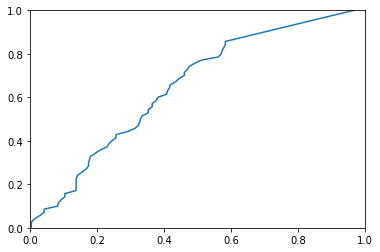

AUC:  0.6163673469387756
Time:  479.909 ms


In [0]:
import warnings
from sklearn.cluster import KMeans
from statsmodels.tsa.ar_model import AR
from sklearn.metrics import mean_squared_error
from math import sqrt
from pandas import read_csv
import pandas as pd
from pandas import DataFrame
from pandas import concat
import numpy as np 
from matplotlib import pyplot
from sklearn.svm import OneClassSVM
from sklearn import preprocessing
import sys

class OneClassSVM_Average_AnomalyDetection:

    @classmethod
    def from_DataFrame(cls,dataframe,window_width, nu, train_rate) -> 'OneClassSVM_AnomalyDetection':
    	return cls(dataframe, window_width, nu, train_rate)

    @classmethod
    def from_file(cls, path, window_width, nu, train_rate) -> 'OneClassSVM_AnomalyDetection':
    	df = read_csv(path, header=0, index_col=0, parse_dates=True,squeeze=True)
    	return cls(df,window_width, nu, train_rate)
     
    def __init__(self,df, window_width, nu, train_rate):
        self.df = df
        self.df = self.df.reset_index(drop=True)
        self.df.rename(columns={'anomaly':'is_anomaly'}, inplace=True)
        self.nu = nu
        self.window_width = window_width
        series = pd.DataFrame(self.df.iloc[:,0].values)  
        self.values = DataFrame(series.values)
        self.dataframe = concat([self.values.shift(1), self.values], axis=1)
        self.dataframe.columns = ['t', 't+1']

        self.train_size = int(len(self.values) * train_rate)

        # train_labeled, test_labeled = self.dataframe.values[1:self.train_size], self.dataframe.values[self.train_size:]
        # self.train_X, self.train_y = train_labeled[:,0], train_labeled[:,1]
        # self.test_X, self.test_y = test_labeled[:,0], test_labeled[:,1]     
        # self.create_persistence()

        # X = series.values
        # self.train, self.test = X[1:self.train_size], X[self.train_size:]    

    def __build_sets(self):
        train_labeled, test_labeled = self.dataframe.values[1:self.train_size], self.dataframe.values[self.train_size:]
        self.train_X, self.train_y = train_labeled[:,0], train_labeled[:,1]
        self.test_X, self.test_y = test_labeled[:,0], test_labeled[:,1]   

        X = self.dataframe.iloc[:,1].values
        self.train, self.test = X[1:self.train_size], X[self.train_size:]    

    def standardize_dataframe(self):
        X = self.dataframe.values
        self.scalar = preprocessing.StandardScaler().fit(X)
        X = self.scalar.transform(X)
        self.dataframe = pd.DataFrame(X)

    def inverse_standardize_dataframe(self):
        X = self.dataframe.values
        X = self.scalar.inverse_transform(X)
        self.dataframe = pd.DataFrame(X)



    def model_persistence(self, x):
        return x
        
    def create_persistence(self):
        rmse = sqrt(mean_squared_error(self.dataframe['t'].iloc[self.train_size:], self.dataframe['t+1'].iloc[self.train_size::]))
#         print('Persistent Model RMSE: %.3f' % rmse)   

    def fit(self):
        self.create_persistence()
        self.standardize_dataframe()
        self.__build_sets()
                
        self.compute_anomalyScores()
        self.inverse_standardize_dataframe()
    
    def getWindowedVectors(self, X):
        vectors = []
        for i,_ in enumerate(X[:-self.window_width+1]):
            vectors.append(X[i:i+self.window_width])
        return vectors

    def compute_anomalyScores(self):
        self.errors = np.zeros_like(self.test)
        # compute anomalies
        warnings.filterwarnings("ignore")

        # history = self.getWindowedVectors(self.train)

        for i,_ in enumerate(self.test[:-self.window_width+1]):
            sys.stdout.write('\r'+str(i)+':'+str(len(self.test) - self.window_width))

            window = self.test[i:i+self.window_width]
            window2D = np.zeros((len(window),2))
            window2D[:,1] = window
            clf=OneClassSVM(nu=self.nu)
            clf.fit(window2D)
            error = clf.decision_function(window2D) 
            error[error>0] = 0
            self.errors[i:i+self.window_width] += error*-10


        # normalize anomaly score
        self.errors[:-self.window_width+1] /= self.window_width
        for i,error in enumerate(self.test[-self.window_width+1:]):
            self.errors[-self.window_width + 1 + i] /=self.window_width-(i+1)

        # self.errors_original = self.errors
        # scalar = preprocessing.MinMaxScaler((0,1)).fit(self.errors.reshape(-1,1))
        # self.errors = scalar.transform(self.errors.reshape(-1,1))*10


    def plot(self):
        df_test = pd.DataFrame(self.df.iloc[self.train_size:].values)

        pyplot.figure(figsize=(50,5))
        pyplot.plot(self.test)
        pyplot.plot(self.errors, color = 'red',  linewidth=0.5)
        pyplot.plot(df_test[df_test[1]==1.].index, df_test[df_test[1]==1.].iloc[:,0].values,'ro')
        pyplot.show()

    def get_roc_auc(self, plot=True, verbose=True):
        # get the predicted errors of the anomaly points
        indices = self.df[self.df['is_anomaly']==1].index >self.train_size
        true_anomaly_predicted_errors = self.errors[self.df[self.df['is_anomaly']==1].index[indices] - self.train_size ]
        if len(true_anomaly_predicted_errors) == 0:
            return np.nan
        # sort them 
        true_anomaly_predicted_errors = np.sort(true_anomaly_predicted_errors,axis=0).reshape(-1)
        true_anomaly_predicted_errors_extended = np.r_[np.linspace(0,true_anomaly_predicted_errors[0],40)[:-1],true_anomaly_predicted_errors]
        true_anomaly_predicted_errors_extended = np.r_[true_anomaly_predicted_errors_extended, true_anomaly_predicted_errors_extended[-1] + np.mean(true_anomaly_predicted_errors_extended)]
                # now iterate thru the predicted errors from small to big
        # for each value look how much other points have equal or bigger error
        FPR = [] # fp/n  https://en.wikipedia.org/wiki/Sensitivity_and_specificity
        TPR = [] # tp/p
        p = len(true_anomaly_predicted_errors)
        Thresholds = []
        for predictederror in true_anomaly_predicted_errors_extended:
            threshold = predictederror
            tp = len(true_anomaly_predicted_errors[true_anomaly_predicted_errors>= threshold])
            fp = len(self.errors[self.errors>=threshold])-len(true_anomaly_predicted_errors[true_anomaly_predicted_errors>=threshold])
            
            fpr =fp/len(self.errors)
            FPR.append(fpr)
            TPR.append(tp/p)
            if verbose:
                print("Threshold: {0:25}  - FP: {1:4} - TP: {2:4} - FPR: {3:21} - TPR: {4:4}".format(threshold,fp, tp, fpr, tp/p))

        import matplotlib.pyplot as plt
        if plot:
            plt.figure()
            plt.axis([0, 1, 0, 1])
            plt.plot(FPR,TPR)
            plt.show() 

        # This is the AUC
        from sklearn.metrics import auc
        print('AUC: ' ,auc(FPR,TPR)        )
        return auc(FPR,TPR)


# iforest = OneClassSVM_AnomalyDetection.from_file('drive/My Drive/MT/Experiments/Univariate/YahooServiceNetworkTraffic/A1Benchmark/real_1.csv',30,0.7,0.3)
# iforest.fit()
# iforest.plot()
# iforest.get_roc_auc(verbose=False)

def concatenate_errors(ar_univariates):
    pci_ = ar_univariates[0]
    errors = np.zeros((len(pci_.errors),dimension))
    errors[:,0] = pci_.errors.T
    # for i in range(1,5):
    for i in range(1,5):
        errors[:,0:i+1] = np.c_[errors[:,:i],ar_univariates[i].errors.reshape(-1,1)]
    return np.min(errors,axis=1)

import datetime
startTime = datetime.datetime.now()

dimension = 5
# df = read_csv(path, header=0, index_col=index_col, parse_dates=True,squeeze=True)
ar_univariates = []
for i in range (5):
    print(i)
    df_univariate = pd.DataFrame(np.c_[df_synthetic.iloc[:,i].values,df_synthetic.iloc[:,-1].values])
    df_univariate.columns = ['V1','is_anomaly']
    ar = OneClassSVM_Average_AnomalyDetection.from_DataFrame(df_univariate,30,0.7,0.3)
    # ar.getAndReadAnaomaliesByPCI(plot=False)
    ar.fit()
    ar_univariates.append(ar)
	
errors = concatenate_errors(ar_univariates)
ar_full = OneClassSVM_Average_AnomalyDetection.from_DataFrame(df_synthetic,30,0.7,0.3)
ar_full.errors = errors
ar_full.get_roc_auc(verbose=False)

endTime = datetime.datetime.now()
diff = endTime - startTime
print('Time: ',diff.microseconds/1000, 'ms')

# iforest = XGBRegressor_AnomalyDetection('Univariate/YahooServiceNetworkTraffic/A1Benchmark/real_4.csv',30,0.7,0.66)
# iforest.fit()
# iforest.plot()
# iforest.get_roc_auc(verbose=False)